This file reads the original data file of interactions from Brose, U. GlobAL daTabasE of traits and food Web Architecture (GATEWAy) version 1.0. iDiv https://doi.org/10.25829/idiv.283-3-756 (2018), https://idata.idiv.de/ddm/Data/ShowData/283?version=3, prints some information about the dataset and formats the data to be used in the link prediction scripts.

Author: Lucy Van Kleunen

Note this was run with Python 3.6.3, numpy 1.19.5, pandas 1.1.5, networkx 2.5.1, matplotlib 3.3.4

In [1]:
import csv
import numpy as np
import unicodedata
import os
import sys
import shutil
sys.path.append("../../Methods/stacking_model") 
from link_prediction_helper import read_from_file
from link_prediction_helper import read_from_file_directed
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import pickle
import random
sys.path.append("..") 
import data_processing_helper
import math
from matplotlib import pyplot as plt

# Add fonts
import matplotlib.font_manager as font_manager
# Add every font at the specified location
font_dir = ['../../../Helvetica']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
plt.rcParams['font.family'] = 'Helvetica'

if not os.path.exists("figures"):
    os.mkdir("figures")
if not os.path.exists("data_details"):
    os.mkdir("data_details")
if not os.path.exists("network_properties"):
    os.mkdir("network_properties")
if not os.path.exists("assortativities"):
    os.mkdir("assortativities")

FONT_SIZE = 15.9

# Don't show extra warnings in final version
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get column indices
DATA_FILE = os.path.join('..','Original_Data','283_2_FoodWebDataBase_2018_12_10.csv')
fw_df = pd.read_csv(DATA_FILE, low_memory=False)
FW_NAME_INDEX = fw_df.columns.get_loc('foodweb.name') 
ECOTYPE_INDEX = fw_df.columns.get_loc('ecosystem.type')

CON_INDEX = fw_df.columns.get_loc('con.taxonomy')
CON_LS_INDEX = fw_df.columns.get_loc('con.lifestage')
CON_TAX_INDEX = fw_df.columns.get_loc('con.taxonomy.level')
CON_MOV_INDEX = fw_df.columns.get_loc('con.movement.type')
CON_MET_INDEX = fw_df.columns.get_loc('con.metabolic.type')
CON_MASS_INDEX = fw_df.columns.get_loc('con.mass.mean.g.')

RES_INDEX = fw_df.columns.get_loc('res.taxonomy')
RES_LS_INDEX = fw_df.columns.get_loc('res.lifestage')
RES_TAX_INDEX = fw_df.columns.get_loc('res.taxonomy.level')
RES_MOV_INDEX = fw_df.columns.get_loc('res.movement.type')
RES_MET_INDEX = fw_df.columns.get_loc('res.metabolic.type')
RES_MASS_INDEX = fw_df.columns.get_loc('res.mass.mean.g.')

INT_TYPE_INDEX = fw_df.columns.get_loc('interaction.type')
INT_CLASS_INDEX = fw_df.columns.get_loc('interaction.classification')

Processed_Data_Folder = os.path.join('..','Processed_Data_Disaggregated_Lifestage')
# For reproducibility of edge randomization used for results
random.seed(25)
np.random.seed(25)

# These are the seeds for the 4 other edge randomization orders used in the results (5x5 fold cross validation across 5 edge randomizations)

# Processed_Data_Folder = os.path.join('..','Processed_Data_Disaggregated_Lifestage_1')
# random.seed(919)
# np.random.seed(919)

# Processed_Data_Folder = os.path.join('..','Processed_Data_Disaggregated_Lifestage_2')
# random.seed(888)
# np.random.seed(888)

# Processed_Data_Folder = os.path.join('..','Processed_Data_Disaggregated_Lifestage_3')
# random.seed(771)
# np.random.seed(771)

# Processed_Data_Folder = os.path.join('..','Processed_Data_Disaggregated_Lifestage_4')
# random.seed(444)
# np.random.seed(444)

if not os.path.exists(Processed_Data_Folder):
    os.makedirs(Processed_Data_Folder)

In [3]:
## CELL 1  ---- INTERACTION RECORD INFORMATION SAVED ---------------

f = open(DATA_FILE,'r')
reader = csv.reader(f)
next(reader)

# Big dictionary used to report information about interaction records:
# {foodweb.name : {ecosystem.type: 'aquatic',
#                  interactions: [(res0,con0), (res1,con1), etc...],
#                  interaction.types: ['predacious', 'herbivorous,' etc...],
#                  interaction.classifications: ['ibi', 'ibi', 'nibi'],
#                  unique_nodes: [res0, con0, res1, con1, etc...],
#                  taxonomy.levels: ['species','genus', 'species', etc...]  # matches with unique nodes 
#                  node.lifestages: {res0: ['larvae'], etc...}}} # matches with unique nodes 
interaction_records = {}
# for making count columns for proportions of interaction type, interaction classification, and taxonomic aggregation
unique_interaction_types = []
unique_interaction_class = []
unique_taxonomy_levels = []

# list of multi-edge details to output to a file to look at in more detail 
multi_edges = []
def add_multi_edge(food_web, res, con):
    multi_edges.append((food_web, res, con))

# Collecting taxonomy level values indexed by node taxonomy across the database, for deciding which later
tax_nodes = {}
def add_taxonomy(spec, spec_tax):
    if spec not in tax_nodes:
        tax_nodes[spec] = [spec_tax]
    else:
        if spec_tax not in tax_nodes[spec]:
            tax_nodes[spec].append(spec_tax)

for row in reader: # Looping through interaction records
    
    food_web = row[FW_NAME_INDEX] # foodweb.name
    eco_type = row[ECOTYPE_INDEX] # ecosystem.type
    
    # consumer species 
    con = row[CON_INDEX]  # con.taxonomy
    con_ls = row[CON_LS_INDEX] # con.lifestage
    con_tax = row[CON_TAX_INDEX] # con.taxonomy.level
    con_tax_clean = data_processing_helper.get_combined_tax(con_tax)

    # resource species 
    res = row[RES_INDEX] # res.taxonomy
    res_ls = row[RES_LS_INDEX] # res.lifestage
    res_tax = row[RES_TAX_INDEX] # res.taxonomy.level
    res_tax_clean = data_processing_helper.get_combined_tax(res_tax)

    # Disaggregate by lifestage for node ID
    con = f'{con}_{con_ls}'
    res = f'{res}_{res_ls}'
    
    add_taxonomy(con, con_tax_clean)
    add_taxonomy(res, res_tax_clean)

    # interaction information 
    int_type = row[INT_TYPE_INDEX] # interaction.type
    int_class = row[INT_CLASS_INDEX] # interaction.classification
    
    if food_web not in interaction_records:
        interaction_records[food_web] = {}
        interaction_records[food_web]['ecosystem.type'] = eco_type
        interaction_records[food_web]['interactions'] = [(res, con)]
        interaction_records[food_web]['interaction.types'] = [int_type]
        interaction_records[food_web]['interaction.classifications'] = [int_class]
        interaction_records[food_web]['unique_nodes'] = [con]
        interaction_records[food_web]['node.lifestages'] = {con: [con_ls]}
        if con != res:
            interaction_records[food_web]['unique_nodes'].append(res)
            interaction_records[food_web]['node.lifestages'][res] = [res_ls]
    else:
        if (res, con) in interaction_records[food_web]['interactions']:
            add_multi_edge(food_web, res, con)
        interaction_records[food_web]['interactions'].append((res, con)) # don't care about duplicates here (want all)
        interaction_records[food_web]['interaction.types'].append(int_type)
        interaction_records[food_web]['interaction.classifications'].append(int_class)
        if con not in interaction_records[food_web]['unique_nodes']:
            interaction_records[food_web]['unique_nodes'].append(con)
            interaction_records[food_web]['node.lifestages'][con] = [con_ls]
        else:
            if con_ls not in interaction_records[food_web]['node.lifestages'][con]:
                interaction_records[food_web]['node.lifestages'][con].append(con_ls)
        if res not in interaction_records[food_web]['unique_nodes']:
            interaction_records[food_web]['unique_nodes'].append(res)
            interaction_records[food_web]['node.lifestages'][res] = [res_ls]
        else:
            if res_ls not in interaction_records[food_web]['node.lifestages'][res]:
                interaction_records[food_web]['node.lifestages'][res].append(res_ls)
    
    # unique categories 
    if int_type not in unique_interaction_types:
        unique_interaction_types.append(int_type)
    if int_class not in unique_interaction_class:
        unique_interaction_class.append(int_class)
    if con_tax_clean not in unique_taxonomy_levels:
        unique_taxonomy_levels.append(con_tax_clean)
    if res_tax_clean not in unique_taxonomy_levels:
        unique_taxonomy_levels.append(res_tax_clean)
        
# Loop through the tax nodes dictionary and identify cases in which there are multiple taxonomic levels saved
for node in tax_nodes:
    if (len(tax_nodes[node]) > 1):
        assert len(tax_nodes[node]) == 2, "more than 2 options (assumed not the case)"
        if "unclassified" in tax_nodes[node]: # if one is unclassified go with the other one
            tax_nodes[node].remove('unclassified')
        else:
            print(f"conflicting taxonomic levels - {node} - {tax_nodes[node]}")      

# Manually change outlier with taxonomic level contradiction
tax_nodes['Gomphonema_NA'] = ['genus']

# Update the interaction records dictionary to have the following vector (matches with unique nodes list)
# foodweb.name : {taxonomy.levels: ['species','genus', 'species', etc...]}
for food_web in interaction_records:
    interaction_records[food_web]['taxonomy.levels'] = []
    for node in interaction_records[food_web]['unique_nodes']:
        interaction_records[food_web]['taxonomy.levels'].append(tax_nodes[node][0])

print(f"number of food webs - {len(interaction_records.keys())}")
print(f"number of unique nodes - {len(tax_nodes.keys())}")
print(f"number of multi-edges: {len(multi_edges)}")

with open('interaction_records.pickle', 'wb') as handle:
    pickle.dump(interaction_records, handle)
with open('unique_interaction_types.pickle', 'wb') as handle:
    pickle.dump(unique_interaction_types, handle)
with open('unique_interaction_class.pickle', 'wb') as handle:
    pickle.dump(unique_interaction_class, handle)
with open('unique_taxonomy_levels.pickle', 'wb') as handle:
    pickle.dump(unique_taxonomy_levels, handle)
with open('tax_nodes.pickle', 'wb') as handle:
    pickle.dump(tax_nodes, handle)
with open('multi_edges.pickle', 'wb') as handle:
    pickle.dump(multi_edges, handle)
    
# Also a taxonomy spreadsheet
df = pd.DataFrame.from_dict(tax_nodes, orient='index')
df.to_csv('tax_nodes.csv')
    
f.close()

conflicting taxonomic levels - Gomphonema_NA - ['genus', 'species']
number of food webs - 290
number of unique nodes - 5688
number of multi-edges: 432


In [4]:
## CELL 2 -- Output a CSV file about interaction records

with open('interaction_records.pickle', 'rb') as handle:
    interaction_records = pickle.load(handle)
with open('unique_interaction_types.pickle', 'rb') as handle:
    unique_interaction_types = pickle.load(handle)
with open('unique_interaction_class.pickle', 'rb') as handle:
    unique_interaction_class = pickle.load(handle)
with open('unique_taxonomy_levels.pickle', 'rb') as handle:
    unique_taxonomy_levels = pickle.load(handle)

print("unique interaction types:")
print(unique_interaction_types)
print("unique interaction classes:")
print(unique_interaction_class)
print("unique taxonomy levels:")
print(unique_taxonomy_levels)
print("number of food webs:")
print(len(list(interaction_records.keys())))

# for the text, print these details:
num_nodes_w_multilife = 0
num_fw_w_multilife = 0
eco_type_multilife = {}
unique_set_multilife = []
multilife_details = {} # fw: spec list of those w multiple lifestages.

# Loop through interaction record dictionary and create a summary dictionary to output to a CSV file
interaction_records_summary = {}
for fw in interaction_records:
    interaction_records_summary[fw] = {}
    eco_type = interaction_records[fw]['ecosystem.type']
    interaction_records_summary[fw]['ecosystem.type'] = eco_type
    interaction_records_summary[fw]['interaction.count'] = len(interaction_records[fw]['interactions'])
    interaction_records_summary[fw]['interaction.count.unique'] = len(set(interaction_records[fw]['interactions']))
    assert len(interaction_records[fw]['interactions']) == len(interaction_records[fw]['interaction.types']), "err 1"
    sum_check = 0
    for uni_type in unique_interaction_types:
        uni_ct = interaction_records[fw]['interaction.types'].count(uni_type)
        sum_check += uni_ct
        interaction_records_summary[fw][f'int.type.{uni_type}'] = uni_ct
    assert sum_check == len(interaction_records[fw]['interaction.types']), f"err sum type - {sum_check}"
    assert len(interaction_records[fw]['interactions']) == len(interaction_records[fw]['interaction.classifications']), "err 2"
    sum_check = 0
    for uni_class in unique_interaction_class:
        uni_ct = interaction_records[fw]['interaction.classifications'].count(uni_class)
        sum_check += uni_ct
        interaction_records_summary[fw][f'int.class.{uni_class}'] = uni_ct
    assert sum_check == len(interaction_records[fw]['interaction.classifications']), f"err sum class - {sum_check}"
    interaction_records_summary[fw]['node.count'] = len(interaction_records[fw]['unique_nodes'])
    assert len(interaction_records[fw]['unique_nodes']) == len(interaction_records[fw]['taxonomy.levels']), "err 3"
    sum_check = 0
    for uni_tax in unique_taxonomy_levels:
        uni_ct = interaction_records[fw]['taxonomy.levels'].count(uni_tax)
        sum_check += uni_ct
        interaction_records_summary[fw][f'node.tax.{uni_tax}'] = uni_ct
        
    assert sum_check == len(interaction_records[fw]['taxonomy.levels']), f"err sum tax - {sum_check}"
    assert len(interaction_records[fw]['unique_nodes']) == len(list(interaction_records[fw]['node.lifestages'].keys())), "err 4"
    multiple_lifestage_ct = 0
    ct = 0
    for node in interaction_records[fw]['node.lifestages']:
        if len(interaction_records[fw]['node.lifestages'][node]) > 1:
            multiple_lifestage_ct += 1
            num_nodes_w_multilife += 1
            if ct == 0:
                num_fw_w_multilife +=1
                ct+=1
                if eco_type not in eco_type_multilife:
                    eco_type_multilife[eco_type] = 1
                else:
                    eco_type_multilife[eco_type] += 1
            if node not in unique_set_multilife:
                unique_set_multilife.append(node)
            if fw not in multilife_details:
                multilife_details[fw] = [node]
            else:
                if node not in multilife_details[fw]:
                    multilife_details[fw].append(node)
    interaction_records_summary[fw]['node.multi.lifestage.ct'] = multiple_lifestage_ct
    self_loop_ct = 0
    for interaction in interaction_records[fw]['interactions']:
        if interaction[0] == interaction[1]:
            self_loop_ct += 1
    interaction_records_summary[fw]['selfloop.ct'] = self_loop_ct
    
print(f"number of nodes with multiple lifestages of interaction: {num_nodes_w_multilife}")
print(f"number of nodes with multiple lifestages of interaction - unique ids: {len(unique_set_multilife)}")
print(f"number of food webs with nodes with multiple lifestages of interaction: {num_fw_w_multilife}")

with open('eco_type_multilife.pickle', 'wb') as handle:
    pickle.dump(eco_type_multilife, handle)
with open('multilife_details.pickle', 'wb') as handle:
    pickle.dump(multilife_details, handle)

print("Example - AEW05")
print(interaction_records_summary['AEW05'])

# Save CSV of the summary object
df = pd.DataFrame.from_dict(interaction_records_summary, orient='index')
df.to_csv('interaction_records_summary.csv')

unique interaction types:
['predacious', 'parasitic', 'herbivorous', 'detritivorous', 'bacterivorous', 'fungivorous', 'NA', 'parasitoid']
unique interaction classes:
['ibi', 'nibi', 'NA']
unique taxonomy levels:
['unclassified', 'family+', 'species', 'genus']
number of food webs:
290
number of nodes with multiple lifestages of interaction: 0
number of nodes with multiple lifestages of interaction - unique ids: 0
number of food webs with nodes with multiple lifestages of interaction: 0
Example - AEW05
{'ecosystem.type': 'terrestrial belowground', 'interaction.count': 1876, 'interaction.count.unique': 1876, 'int.type.predacious': 1699, 'int.type.parasitic': 0, 'int.type.herbivorous': 41, 'int.type.detritivorous': 40, 'int.type.bacterivorous': 18, 'int.type.fungivorous': 78, 'int.type.NA': 0, 'int.type.parasitoid': 0, 'int.class.ibi': 1693, 'int.class.nibi': 183, 'int.class.NA': 0, 'node.count': 126, 'node.tax.unclassified': 17, 'node.tax.family+': 16, 'node.tax.species': 73, 'node.tax.ge

number of nodes with unique taxonomy-lifestage combination: 5688


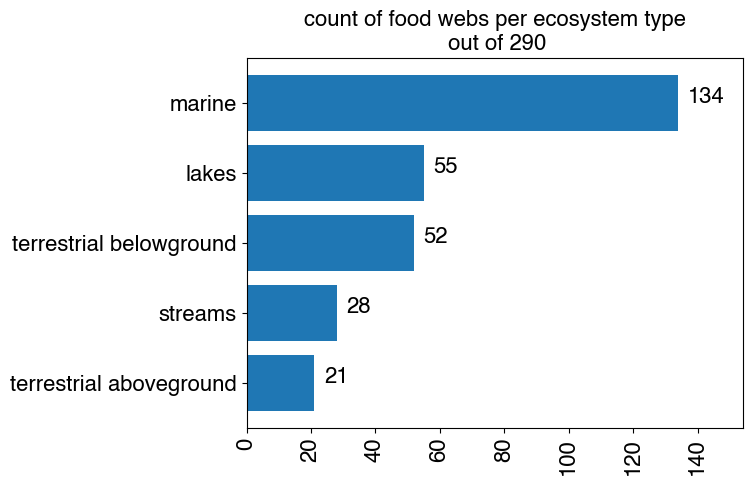

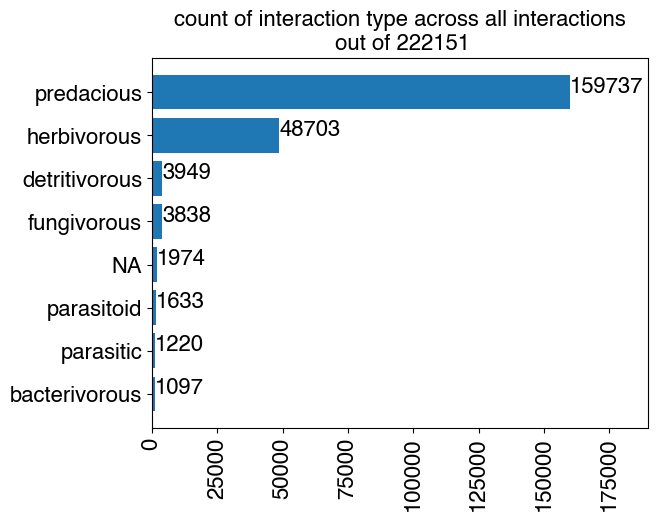

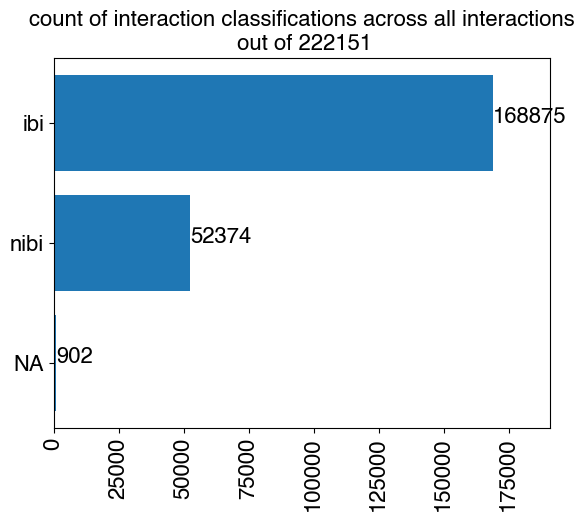

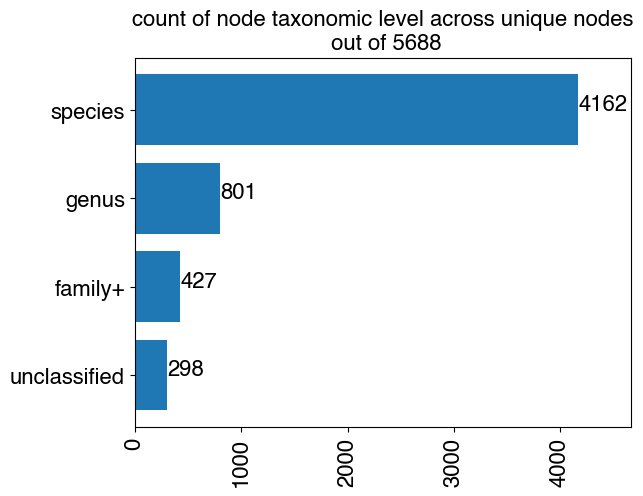

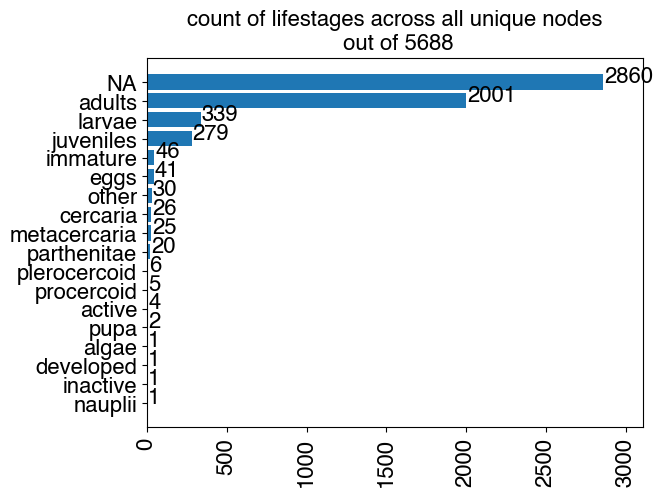

In [5]:
## CELL 3 -- Overall count visualizations

with open('interaction_records.pickle', 'rb') as handle:
    interaction_records = pickle.load(handle)
with open('tax_nodes.pickle', 'rb') as handle:
    tax_nodes = pickle.load(handle)
with open('eco_type_multilife.pickle', 'rb') as handle:
    eco_type_multilife = pickle.load(handle)

fw_num = 290
int_num = 222151
node_num = 5688

eco_cts = {}
int_types = {}
int_classes = {}
unique_node_lifestage = []
for fw in interaction_records:
    eco_type = interaction_records[fw]['ecosystem.type']
    int_types_curr = interaction_records[fw]['interaction.types']
    int_class_curr = interaction_records[fw]['interaction.classifications']
    lifestages_curr = interaction_records[fw]['node.lifestages']
    if eco_type not in eco_cts:
        eco_cts[eco_type] = 1
    else:
        eco_cts[eco_type] += 1
    for intt in int_types_curr:
        if intt not in int_types:
            int_types[intt] = 1
        else:
            int_types[intt] += 1
    for intc in int_class_curr:
        if intc not in int_classes:
            int_classes[intc] = 1
        else:
            int_classes[intc] += 1
    for node in lifestages_curr:
        for ls in lifestages_curr[node]:
            if (node,ls) not in unique_node_lifestage:
                unique_node_lifestage.append((node,ls))
            
tax_cts = {}
for node in tax_nodes:
    tax_curr = tax_nodes[node][0]
    if tax_curr not in tax_cts:
        tax_cts[tax_curr] = 1
    else:
        tax_cts[tax_curr] += 1

node_ls_ct = len(unique_node_lifestage)
print(f"number of nodes with unique taxonomy-lifestage combination: {node_ls_ct}")

lifestage_ct = {}
for pair in unique_node_lifestage:
    lifestage_curr = pair[1]
    if lifestage_curr not in lifestage_ct:
        lifestage_ct[lifestage_curr] = 1
    else:
        lifestage_ct[lifestage_curr] += 1
            
data_processing_helper.sorted_count_plot(eco_cts, fw_num, 20, 3, "food webs per ecosystem type", "fw_ecosystem_types",FONT_SIZE)
data_processing_helper.sorted_count_plot(int_types, int_num, 30000, 5, "interaction type across all interactions",\
                                         "interaction_types",FONT_SIZE)
data_processing_helper.sorted_count_plot(int_classes, int_num, 22000, 5, "interaction classifications across all interactions",\
                                         "interaction_classes",FONT_SIZE)
data_processing_helper.sorted_count_plot(tax_cts, node_num, 500, 5, "node taxonomic level across unique nodes",\
                                         "node_tax_levels",FONT_SIZE)
data_processing_helper.sorted_count_plot(lifestage_ct, node_ls_ct, 250, 5,\
                                         "lifestages across all unique nodes",\
                                         "node_lifestages",FONT_SIZE)

In [6]:
## CELL 4 - Looking more at multi-edge details to see when these happen (takes a few min to run this)

f = open(DATA_FILE,'r')
reader = csv.reader(f)
next(reader)
with open('multi_edges.pickle', 'rb') as handle:
    multi_edges = pickle.load(handle)

print(multi_edges[0])
    
# #list of multi-edge details to output to a file to look at in more detail 
multi_edge_id = 0
multi_edge_ids = {}
multi_edge_details = []
def add_multi_edge(uid, food_web, eco_type, res, con, res_ls, con_ls, res_mass, con_mass, res_met,\
                   con_met, res_mov, con_mov, int_type, res_tax, con_tax):
    multi_edge_details.append({'id':uid,\
                        'food.web':food_web,\
                        'ecosystem.type': eco_type,\
                       'res.taxonomy': res,\
                       'con.taxonomy':con,\
                       'res.lifestage':res_ls,\
                       'con.lifestage':con_ls,\
                        'res.mass':res_mass,\
                       'con.mass':con_mass,\
                        'res.met':res_met,\
                       'con.met':con_met,\
                        'res.mov':res_mov,\
                       'con.mov':con_mov,\
                        'int.type': int_type,\
                        'res.taxonomy.level':res_tax,\
                        'con.taxonomy.level':con_tax})
    
for row in reader: # Looping through interaction records + saving multi-edge full details 
    
    food_web = row[FW_NAME_INDEX] # foodweb.name
    eco_type = row[ECOTYPE_INDEX] # ecosystem.type
    
    # consumer species 
    con = row[CON_INDEX]  # con.taxonomy
    con_ls = row[CON_LS_INDEX] # con.lifestage
    con_tax = data_processing_helper.get_combined_tax(row[CON_TAX_INDEX]) # con.taxonomy.level
    con_met = row[CON_MET_INDEX] # con.metabolic.type
    con_mov = row[CON_MOV_INDEX] # con.movement.type
    con_mass = float(row[CON_MASS_INDEX]) # con.mass.mean.g.
    
    # resource species 
    res = row[RES_INDEX] # res.taxonomy
    res_ls = row[RES_LS_INDEX] # res.lifestage
    res_tax = data_processing_helper.get_combined_tax(row[RES_TAX_INDEX]) # res.taxonomy.level
    res_met = row[RES_MET_INDEX] # res.metabolic.type
    res_mov = row[RES_MOV_INDEX] # res.movement.type
    res_mass = float(row[RES_MASS_INDEX]) # res.mass.mean.g.
    
    # Lifestage disaggregation
    con = f'{con}_{con_ls}'
    res = f'{res}_{res_ls}'
    
    int_type = row[INT_TYPE_INDEX] # interaction.type
    
    if (food_web, res, con) in multi_edges:
        if (food_web, res, con) in multi_edge_ids:
            uid = multi_edge_ids[(food_web, res, con)]
        else:
            uid = multi_edge_id
            multi_edge_id += 1
            multi_edge_ids[(food_web, res, con)] = uid
        add_multi_edge(uid, food_web, eco_type, res, con, res_ls, con_ls, res_mass, con_mass, res_met,\
                   con_met, res_mov, con_mov, int_type, res_tax, con_tax)      
        
# Output a CSV
multi_df = pd.DataFrame.from_dict(multi_edge_details)
multi_df.to_csv('multi_edges.csv')

multi_fws = []
for me in multi_edge_details:
    multi_fws.append(me['food.web'])
print(f"number of food webs with multi-edges : {len(set(multi_fws))}")
print(f"number of multi-edges: {len(multi_edge_details)}")

with open('multi_edge_details.pickle', 'wb') as handle:
    pickle.dump(multi_edge_details, handle)

f.close()

('Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1', 'Psychodidae_adults', 'Tettigoniidae_NA')
number of food webs with multi-edges : 17
number of multi-edges: 861


In [7]:
## CELL 5 - Looking more at multi-edge details to see when these happen 

with open('multi_edge_details.pickle', 'rb') as handle:
    multi_edge_details = pickle.load(handle)

multi_edge_id_map = {} # arrange these by unique multi-edge id
for multi_edge in multi_edge_details:
    curr_id = multi_edge['id']
    if curr_id not in multi_edge_id_map:
        multi_edge_id_map[curr_id] =  [multi_edge]
    else:
        multi_edge_id_map[curr_id].append(multi_edge)

num_uni_me = len(list(multi_edge_id_map.keys()))
print(f"number of unique multi-edge (fw, res, con) combo: {num_uni_me}")

equal_two = 0 
over_two = 0
ls_diff_ct = 0
int_diff_ct = 0
non_spec_ct = 0
none_ct = 0
mass_diff_ct = 0
met_diff_ct = 0
mov_diff_ct = 0

mass_diff_and_ls_diff = 0
mass_diff_and_tax = 0
met_diff_and_ls_diff = 0
met_diff_and_tax = 0
mov_diff_and_ls_diff = 0
mov_diff_and_tax = 0

nothing = {}
ct_nothing_over_two = 0

for uid in multi_edge_id_map:
    curr_edge = multi_edge_id_map[uid]
    fw = curr_edge[0]['food.web']
    res_id = curr_edge[0]['res.taxonomy']
    con_id = curr_edge[0]['con.taxonomy']
    assert len(curr_edge) != 1, f"not a multi-edge: {multi_edge_id_map[uid]}"
    # most of them -- an interaction is repeated between two species w/ 1 at diff lifestage
    over_two_check = False
    if len(curr_edge) == 2:
        equal_two +=1
    else:
        assert len(curr_edge) > 2, f"not a multi-edge 2: {multi_edge_id_map[uid]}"
        over_two_check = True
        over_two +=1
    # count the number where at least one node differs in lifestage in at least one of the repeated interactions
    ls_diff = False
    con_ls0 = curr_edge[0]['con.lifestage']
    res_ls0 = curr_edge[0]['res.lifestage']
    for i in range(0,len(curr_edge)):
        if curr_edge[i]['con.lifestage'] != con_ls0:
            ls_diff = True
        if curr_edge[i]['res.lifestage'] != res_ls0:
            ls_diff = True
    if ls_diff:
        ls_diff_ct += 1
    # count the number that involve an interaction type difference
    int_diff = False
    int_type0 = curr_edge[0]['int.type']
    for i in range(0,len(curr_edge)):
        if curr_edge[i]['int.type'] != int_type0:
            int_diff = True
    if int_diff:
        int_diff_ct += 1
    # count the number in which at least one node has a non-species taxonomic level (with combined tax levels)
    non_spec = False
    for i in range(0,len(curr_edge)):
        if curr_edge[i]['con.taxonomy.level'] != 'species':
            non_spec = True
        if curr_edge[i]['res.taxonomy.level'] != 'species':
            non_spec = True
    if non_spec:
        non_spec_ct += 1
    if not ls_diff and not int_diff and not non_spec:
        none_ct += 1
    # count the number in which there is at least one difference in mass value across the same node
    mass_diff = False
    con_mass0 = curr_edge[0]['con.mass']
    res_mass0 = curr_edge[0]['res.mass']
    for i in range(0,len(curr_edge)):
        con_mass = curr_edge[i]['con.mass']
        res_mass = curr_edge[i]['res.mass']
        if con_mass != con_mass0:
            mass_diff = True
        if res_mass != res_mass0:
            mass_diff = True
    if mass_diff:
        mass_diff_ct += 1
    # count the number in which there is at least one difference in met type value across the same node
    met_diff = False
    con_met0 = curr_edge[0]['con.met']
    res_met0 = curr_edge[0]['res.met']
    for i in range(0,len(curr_edge)):
        con_met = curr_edge[i]['con.met']
        res_met = curr_edge[i]['res.met']
        if con_met != con_met0:
            met_diff = True
        if res_met != res_met0:
            met_diff = True
    if met_diff:
        met_diff_ct += 1
    # count the number in which there is at least one difference in mov type value across the same node 
    mov_diff = False
    con_mov0 = curr_edge[0]['con.mov']
    res_mov0 = curr_edge[0]['res.mov']
    for i in range(0,len(curr_edge)):
        con_mov = curr_edge[i]['con.mov']
        res_mov = curr_edge[i]['res.mov']
        if con_mov != con_mov0:
            mov_diff = True
        if res_mov != res_mov0:
            mov_diff = True
    if mov_diff:
        mov_diff_ct += 1
    
    # combos
    if mass_diff and ls_diff:
        mass_diff_and_ls_diff += 1
    if mass_diff and non_spec:
        mass_diff_and_tax += 1
    if met_diff and ls_diff:
        met_diff_and_ls_diff += 1
    if met_diff and non_spec:
        met_diff_and_tax += 1
    if mov_diff and ls_diff:
        mov_diff_and_ls_diff += 1
    if mov_diff and non_spec:
        mov_diff_and_tax += 1
        
    con_ls0 = curr_edge[0]['con.lifestage']
    res_ls0 = curr_edge[0]['res.lifestage']
    con_mov0 = curr_edge[0]['con.mov']
    res_mov0 = curr_edge[0]['res.mov']
    con_mass0 = curr_edge[0]['con.mass']
    res_mass0 = curr_edge[0]['res.mass']
    con_met0 = curr_edge[0]['con.met']
    res_met0 = curr_edge[0]['res.met']
    for i in range(1,len(curr_edge)):
        con_mov = curr_edge[i]['con.mov']
        res_mov = curr_edge[i]['res.mov']
        con_mass = curr_edge[i]['con.mass']
        res_mass = curr_edge[i]['res.mass']
        con_met = curr_edge[i]['con.met']
        res_met = curr_edge[i]['res.met']
        con_ls  = curr_edge[i]['con.lifestage']
        res_ls = curr_edge[i]['res.lifestage']
        # Is there one completely the same in terms of traits and lifestage?
        if con_ls0 == con_ls and res_ls0 == res_ls and con_mov == con_mov0 and res_mov == res_mov0 and con_mass == con_mass0\
        and res_mass == res_mass0 and con_met == con_met0 and res_met == res_met0:
            if (fw, res_id, con_id) not in nothing:
                nothing[(fw, res_id, con_id)] = uid
                if over_two_check:
                    ct_nothing_over_two += 1
            
print(f"number of unique multi-edges where there are exactly 2 the same - {equal_two}")
print(f"number of unique multi-edges where there are more than 2 the same - {over_two}")
assert equal_two+over_two == num_uni_me, "don't add up to unique me"
print(f"number of unique multi-edges where there is a lifestage difference - {ls_diff_ct}")
print(f"percent of unique multi-edges where there is a lifestage difference - {ls_diff_ct/num_uni_me*100}")
print(f"number of unique multi-edges where there is an interaction type difference - {int_diff_ct}")
print(f"percent of unique multi-edges where there is an interaction type difference - {int_diff_ct/num_uni_me*100}")
print(f"number of unique multi-edges where there is a node not at species level - {non_spec_ct}")
print(f"percent of unique multi-edges where there is a node not at species level - {non_spec_ct/num_uni_me*100}")
print(f"number of unique multi-edges not in any of these three categories - {none_ct}")
print(" --- trait differences --")
print(f"number of unique multi-edges where there is a mass difference- {mass_diff_ct}")
print(f"percent of unique multi-edges where there is a mass difference- {mass_diff_ct/num_uni_me*100} -- \
{mass_diff_and_ls_diff/mass_diff_ct*100} percent of these also have lifestage differences -- \
{mass_diff_and_tax/mass_diff_ct*100} percent of these also have non-species taxonomic levels")
print(" ")
print(f"number of unique multi-edges where there is a met difference- {met_diff_ct}")
print(f"number with no lifestage, mass, mov, met difference: {len(nothing)}")
print(f"number of these from a set of over two: {ct_nothing_over_two}")

with open('multi_edge_nothing.pickle', 'wb') as handle:
    pickle.dump(nothing, handle)

number of unique multi-edge (fw, res, con) combo: 429
number of unique multi-edges where there are exactly 2 the same - 426
number of unique multi-edges where there are more than 2 the same - 3
number of unique multi-edges where there is a lifestage difference - 0
percent of unique multi-edges where there is a lifestage difference - 0.0
number of unique multi-edges where there is an interaction type difference - 1
percent of unique multi-edges where there is an interaction type difference - 0.2331002331002331
number of unique multi-edges where there is a node not at species level - 234
percent of unique multi-edges where there is a node not at species level - 54.54545454545454
number of unique multi-edges not in any of these three categories - 194
 --- trait differences --
number of unique multi-edges where there is a mass difference- 15
percent of unique multi-edges where there is a mass difference- 3.4965034965034967 -- 0.0 percent of these also have lifestage differences -- 93.33333

In [8]:
## CELL 6 - looking specifically at these with no trait differences
with open('multi_edge_nothing.pickle', 'rb') as handle:
    multi_edge_nothing = pickle.load(handle)
    
f = open(DATA_FILE,'r')
g = open('multi_edge_sametraits.csv','w')
reader = csv.reader(f)
writer = csv.writer(g, dialect='excel')
header = next(reader)
header = ['multi_edge_id'] + header
writer.writerow(header)
for row in reader:
    food_web = row[FW_NAME_INDEX] # foodweb.name
    con = row[CON_INDEX]  # con.taxonomy
    con_ls = row[CON_LS_INDEX] # con.lifestage
    res = row[RES_INDEX] # res.taxonomy
    res_ls = row[RES_LS_INDEX] # con.lifestage
    con = f'{con}_{con_ls}'
    res = f'{res}_{res_ls}'
    if (food_web, res, con) in multi_edge_nothing:
        writer.writerow([multi_edge_nothing[(food_web, res, con)]] + row)
        
f.close()
g.close()

In [9]:
## CELL 7 - Assign final set of interactions / nodes to the food webs
## Interactions to remove: parasitism, multi-edges, self-loops 

with open('interaction_records.pickle', 'rb') as handle:
    interaction_records = pickle.load(handle)
with open('multi_edges.pickle', 'rb') as handle:
    multi_edges = pickle.load(handle)
        
# Keep track of how many food webs this changes things in 
number_parasitic = 0
parasitic_eco_type = {}
fw_num_parasitic = {}
number_multiedges = 0
number_nodes_change = 0
multi_edge_difference = 0
sl_trimmed = 0
sl_fws = []
sl_eco_type = {}
fw_num_sl = {}
p_trimmed = 0 
slp_overlap = 0
me_eco_type = {}
nnc_eco_type = {}
number_overall_nodes = 0

total_multi = []

# {foodweb.name : {interactions: [(res0,con0), (res1,con1), etc...],
#                  unique_nodes: [res0, con0, res1, con1, etc...]}}
interactions_final = {}

NA_removed = 0
fw_parasite_removed = []

overall_edges_before = 0
overall_edges = 0
overall_unique_nodes = []
for fw in interaction_records:
    interactions_final[fw] = {}
    multis_set = list(set([ele for ele in interaction_records[fw]['interactions'] if interaction_records[fw]['interactions'].count(ele) > 1]))
    total_multi += list(multis_set)
    eco_type = interaction_records[fw]['ecosystem.type']
    if interaction_records[fw]['interaction.types'].count('parasitic') > 0 \
    or interaction_records[fw]['interaction.types'].count('parasitoid') > 0:
        number_parasitic += 1
        if eco_type not in parasitic_eco_type:
            parasitic_eco_type[eco_type] = 1
        else:
            parasitic_eco_type[eco_type] += 1
        fw_num_parasitic[fw] = interaction_records[fw]['interaction.types'].count('parasitic')+interaction_records[fw]['interaction.types'].count('parasitoid')
    assert len(interaction_records[fw]['interactions']) == len(interaction_records[fw]['interaction.types']), "length err"
    overall_edges_before += len(interaction_records[fw]['interactions'])
    interactions_new = []
    curr_sl_ct = 0
    for i in range(0,len(interaction_records[fw]['interactions'])):
        curr_interaction = interaction_records[fw]['interactions'][i]
        curr_type = interaction_records[fw]['interaction.types'][i]
        self_loop = True if curr_interaction[0] == curr_interaction[1] else False
        if curr_type != 'parasitic' and curr_type != 'parasitoid' and self_loop == False:
            if curr_type == 'NA' and fw == 'Carpinteria':
                NA_removed += 1
            else:
                interactions_new.append(curr_interaction)
        else:
            if self_loop:
                sl_trimmed +=1
                if fw not in sl_fws:
                    sl_fws.append(fw)
                curr_sl_ct += 1
            if curr_type == 'parasitic' or curr_type == 'parasitoid':
                if fw not in fw_parasite_removed:
                    fw_parasite_removed.append(fw)
                p_trimmed +=1
                if self_loop:
                    slp_overlap += 1
    fw_num_sl[fw] = curr_sl_ct
    # look at multi-edges:
    multis_set = list(set([ele for ele in interactions_new if interactions_new.count(ele) > 1]))
    for multi in multis_set:
        assert (fw, multi[0], multi[1]) in multi_edges, "not in multi edgs -{(fw, multi[0], multi[1])}"
    # removing multi-edges (only unique interactions)
    interaction_set = set(interactions_new)    
    if len(interactions_new) != len(interaction_set):
        number_multiedges += 1
        if eco_type not in me_eco_type:
            me_eco_type[eco_type] = 1
        else:
            me_eco_type[eco_type] += 1
        multi_edge_difference += (len(interactions_new)-len(interaction_set))
    overall_edges += len(interaction_set)
    # For reproducing the same processed data each time we want to enforce an order
    interaction_set_ordered = sorted(list(interaction_set))
    interactions_final[fw]['interactions'] = interaction_set_ordered
    unique_nodes = []
    for interaction in interaction_set_ordered:
        if interaction[0] not in unique_nodes:
            unique_nodes.append(interaction[0])
        if interaction[1] not in unique_nodes:
            unique_nodes.append(interaction[1])
    if len(unique_nodes) != len(interaction_records[fw]['unique_nodes']):
        number_nodes_change +=1
        if eco_type not in nnc_eco_type:
            nnc_eco_type[eco_type] = 1
        else:
            nnc_eco_type[eco_type] += 1
    interactions_final[fw]['unique_nodes'] = unique_nodes
    number_overall_nodes += len(unique_nodes)
    for node in unique_nodes:
        if node not in overall_unique_nodes:
            overall_unique_nodes.append(node)

for fw in sl_fws:
    eco_type = interaction_records[fw]['ecosystem.type']
    if eco_type not in sl_eco_type:
        sl_eco_type[eco_type] = 1
    else:
        sl_eco_type[eco_type] += 1
    
print(f"number of interactions before: {overall_edges_before}" )
print(f"number of interactions in the final dataset: {overall_edges}" )
print(f"number of nodes in the final dataset: {number_overall_nodes}" )
print(f"number of unique nodes in the final dataset: {len(overall_unique_nodes)}")
print(f"number of food webs: {len(list(interactions_final.keys()))}")
print(f"number self-loops trimmed - {sl_trimmed}")
print(f"number of food webs with self-loops - {len(sl_fws)}")
print(f"number parasitic trimmed - {p_trimmed}")
print(f"number NA interaction type trimmed - {NA_removed}")
print(f"number of food webs with parasitic interactions - {number_parasitic}")
print(f"number parasitic self-loops trimmed - {slp_overlap}")
print(f"number of food webs with multi-edges: {number_multiedges}")
print(f"number of multi-edges removed: {multi_edge_difference}")
print(f"number of food webs where trimming interactions changes the number of nodes: {number_nodes_change}")

with open('interactions_final.pickle', 'wb') as handle:
    pickle.dump(interactions_final, handle)
with open('parasitic_eco_type.pickle', 'wb') as handle:
     pickle.dump(parasitic_eco_type, handle)
with open('sl_eco_type.pickle', 'wb') as handle:
     pickle.dump(sl_eco_type, handle)
with open('me_eco_type.pickle', 'wb') as handle:
     pickle.dump(me_eco_type, handle)
with open('nnc_eco_type.pickle', 'wb') as handle:
     pickle.dump(nnc_eco_type, handle)
with open('fw_num_parasitic.pickle', 'wb') as handle:
     pickle.dump(fw_num_parasitic, handle)
with open('fw_num_sl.pickle', 'wb') as handle:
     pickle.dump(fw_num_sl, handle)
with open(os.path.join(Processed_Data_Folder,'fw_parasite_removed.pickle'), 'wb') as handle:
     pickle.dump(fw_parasite_removed, handle)
        
print(len(total_multi))

print(f"food webs with parasites removed: {fw_parasite_removed}")

number of interactions before: 222151
number of interactions in the final dataset: 213797
number of nodes in the final dataset: 19077
number of unique nodes in the final dataset: 5562
number of food webs: 290
number self-loops trimmed - 3275
number of food webs with self-loops - 271
number parasitic trimmed - 2853
number NA interaction type trimmed - 1920
number of food webs with parasitic interactions - 20
number parasitic self-loops trimmed - 1
number of food webs with multi-edges: 16
number of multi-edges removed: 307
number of food webs where trimming interactions changes the number of nodes: 13
429
food webs with parasites removed: ['Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1', 'Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown2', 'Grand Caricaie  marsh dominated by Cladietum marisci, not mown  ClControl1', 'Grand Caricaie  marsh dominated by Cladietum marisci, not mown  ClControl2', 'Grand Caricaie  marsh dominated by Schoenus nigricans, 

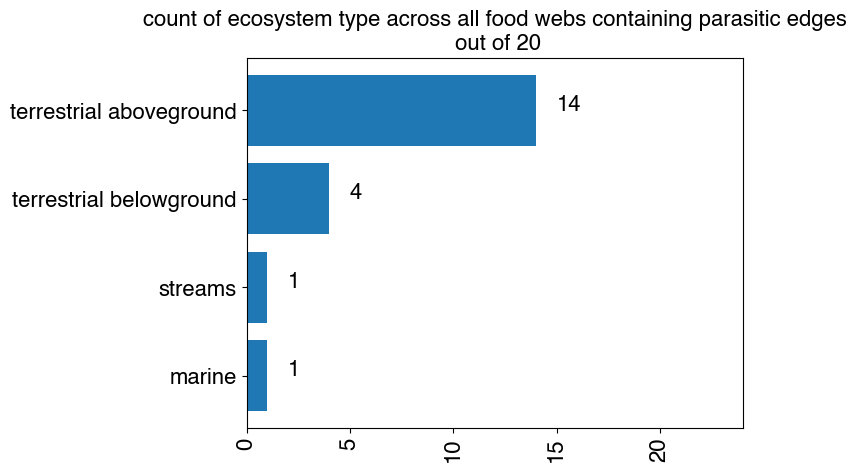

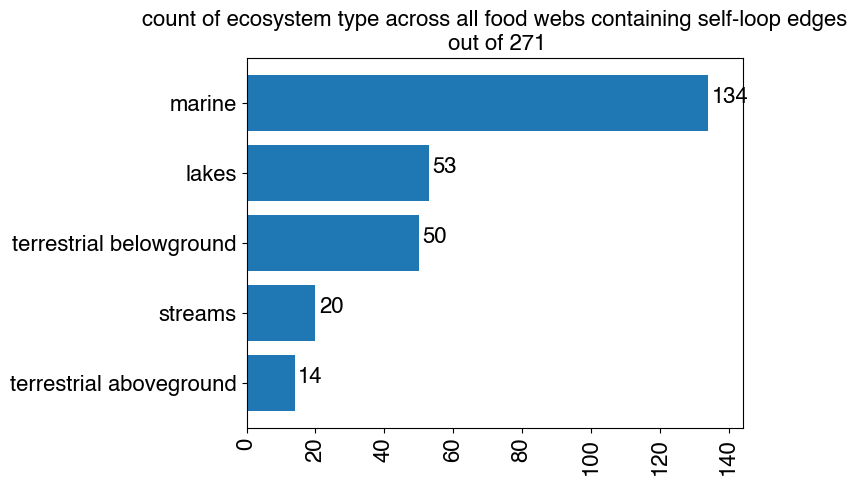

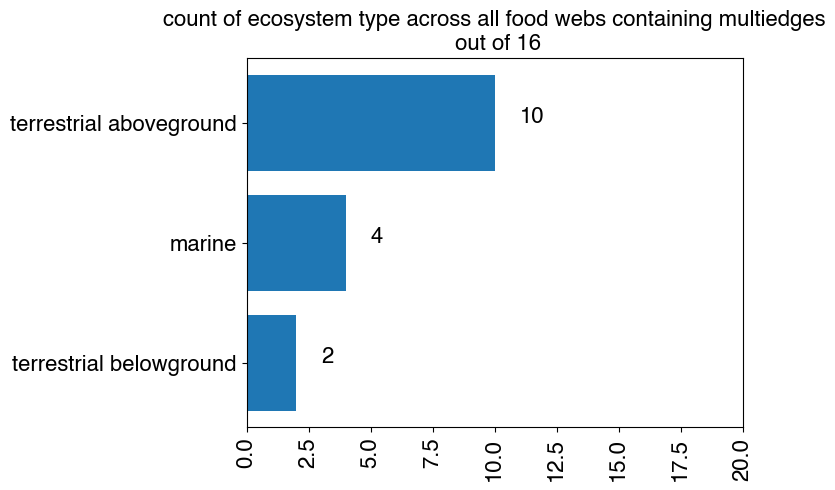

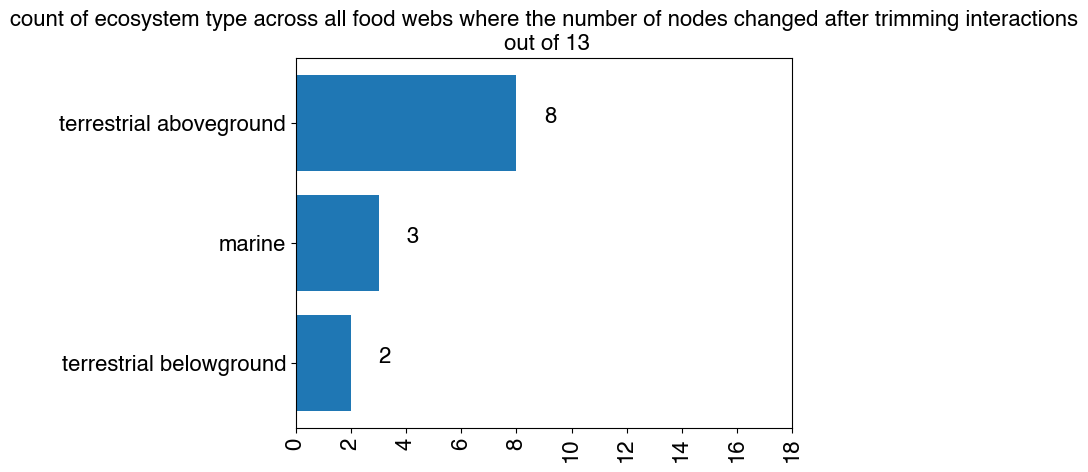

In [10]:
## CELL 8 - Look at ecosystem types of this different categories of trimmed interactions

with open('parasitic_eco_type.pickle', 'rb') as handle:
    parasitic_eco_type = pickle.load(handle)
fw_parasites = 20

data_processing_helper.sorted_count_plot(parasitic_eco_type, fw_parasites, 10, 1,\
            "ecosystem type across all food webs containing parasitic edges", "eco_type_parasite",FONT_SIZE)

with open('sl_eco_type.pickle', 'rb') as handle:
    sl_eco_type = pickle.load(handle)
fw_sl = 271

data_processing_helper.sorted_count_plot(sl_eco_type, fw_sl, 10, 1,\
            "ecosystem type across all food webs containing self-loop edges", "eco_type_selfloop",FONT_SIZE)

with open('me_eco_type.pickle', 'rb') as handle:
    me_eco_type = pickle.load(handle)
fw_me = 16

data_processing_helper.sorted_count_plot(me_eco_type, fw_me, 10, 1,\
            "ecosystem type across all food webs containing multiedges", "eco_type_multiedge",FONT_SIZE)

with open('nnc_eco_type.pickle', 'rb') as handle:
    nnc_eco_type = pickle.load(handle)
fw_nnc = 13
data_processing_helper.sorted_count_plot(nnc_eco_type, fw_nnc, 10, 1,\
"ecosystem type across all food webs where the number of nodes changed after trimming interactions",\
                                         "eco_type_nodechange",FONT_SIZE)

In [11]:
## CELL 9 - Go through and collect trait values for the final set of nodes in each food web

f = open(DATA_FILE,'r')
reader = csv.reader(f)
next(reader)

with open('interactions_final.pickle', 'rb') as handle:
    interactions_final = pickle.load(handle)
    
# {fw.id: {spec_id: [list of the trait values], etc.}, etc.} 
node_masses = {} # for non-missing masses 
node_mets = {}
node_movs = {}

for row in reader: # Looping through interaction records
    
    fw = row[FW_NAME_INDEX] # foodweb.name
    
    con = row[CON_INDEX]  # con.taxonomy
    con_met = row[CON_MET_INDEX] # con.metabolic.type
    con_mov = row[CON_MOV_INDEX] # con.movement.type
    con_mass = float(row[CON_MASS_INDEX]) # con.mass.mean.g.
    con_ls = row[CON_LS_INDEX] # con.lifestage
    
    res = row[RES_INDEX] # res.taxonomy
    res_met = row[RES_MET_INDEX] # res.metabolic.type
    res_mov = row[RES_MOV_INDEX] # res.movement.type
    res_mass = float(row[RES_MASS_INDEX]) # res.mass.mean.g.
    res_ls = row[RES_LS_INDEX] # res.lifestage
    
    con = f'{con}_{con_ls}'
    res = f'{res}_{res_ls}'
    
    if fw not in node_masses:
        node_masses[fw] = {}
    if fw not in node_mets:
        node_mets[fw] = {}
    if fw not in node_movs:
        node_movs[fw] = {}
    
    if con in interactions_final[fw]['unique_nodes']:
                
        if con not in node_masses[fw]:
            node_masses[fw][con] = []
        if con_mass != -999: # missing
            node_masses[fw][con].append(con_mass)
            
        if con not in node_mets[fw]:
            node_mets[fw][con] = []
        node_mets[fw][con].append(con_met)
        
        if con not in node_movs[fw]:
            node_movs[fw][con] = []
        node_movs[fw][con].append(con_mov)
        
    if res in interactions_final[fw]['unique_nodes']:
        
        if res not in node_masses[fw]:
            node_masses[fw][res] = []
        if res_mass != -999: # missing 
            node_masses[fw][res].append(res_mass)

        if res not in node_mets[fw]:
            node_mets[fw][res] = []
        node_mets[fw][res].append(res_met)
        
        if res not in node_movs[fw]:
            node_movs[fw][res] = []
        node_movs[fw][res].append(res_mov)

with open('node_masses.pickle', 'wb') as handle:
    pickle.dump(node_masses, handle)
with open('node_mets.pickle', 'wb') as handle:
    pickle.dump(node_mets, handle)
with open('node_movs.pickle', 'wb') as handle:
    pickle.dump(node_movs, handle)

f.close()

print(node_masses["Carpinteria"]["Epipellic flora_adults"])

[]


In [12]:
## CELL 10 - Check for any metabolic type conflicts
## If there is NA and then another value, choose the other value.

with open('node_mets.pickle', 'rb') as handle:
    node_mets = pickle.load(handle)
    
ct_met_conflict = 0
scenario_one = 0
scenario_two = 0
node_mets_final = {}
for fw in node_mets:
    node_mets_final[fw] = {}
    for species in node_mets[fw]:
        if len(set(node_mets[fw][species])) > 1:
            print("metabolic type conflict:")
            print(f"food web - {fw}")
            print(f"species - {species}")
            print(f"{set(node_mets[fw][species])}")
            ct_met_conflict+=1
            # pick the one that isn't na if 2 and one is na
            if len(set(node_mets[fw][species])) == 2 and 'NA' in set(node_mets[fw][species]):
                setlist = sorted(list(set(node_mets[fw][species])))
                setlist.remove('NA')
                node_mets_final[fw][species] = setlist
                scenario_one +=1
            else:
                scenario_two +=1 
                setlist = sorted(list(set(node_mets[fw][species])))
                if 'NA' in setlist:
                    setlist.remove('NA')
                node_mets_final[fw][species] = setlist
        else:
            # one unique value
            node_mets_final[fw][species] = [node_mets[fw][species][0]]
print(f"number of nodes with metabolic type conflict in a food web: {ct_met_conflict}")
print(f"number taken care of if you don't choose NA out of 2: {scenario_one}")
print(f"exceptions (list in multiple columns): {scenario_two}")

# Print all the nodes with metabolic type NA or other
for fw in node_mets_final:
    for species in node_mets_final[fw]:
        assert len(node_mets_final[fw][species]) == 1, "unexpected multiple metabolic type"
        curr_met_type = node_mets_final[fw][species][0]
        if curr_met_type == "NA":
            print(f"Metabolic type NA: {fw} -- {species}")
        if curr_met_type == "other":
            print(f"Metabolic type other: {fw} -- {species}")

# Fill in metabolic type information for those with metabolic type "NA"
node_mets_final["Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1"]["Trichoptera_larvae"] = ["invertebrate"] # aquatic insect
node_mets_final["Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown2"]["Trichoptera_larvae"] = ["invertebrate"] # aquatic insect
node_mets_final["Chilean Intertidal Curaumilla"]["plankton_NA"] = ["primary producer"]
node_mets_final["Chilean Intertidal El Quisco"]["plankton_NA"] = ["primary producer"]
node_mets_final["Chilean Intertidal Las Cruces"]["plankton_NA"] = ["primary producer"]
node_mets_final["Chilean Intertidal Los Molles"]["plankton_NA"] = ["primary producer"]
node_mets_final["Chesapeake Bay"]["Carcinus sp._adults"] = ["invertebrate"] # crab genus
node_mets_final["Chesapeake Bay"]["Portunus spinimanus_adults"] = ["invertebrate"] # blotched swimming crab
node_mets_final["Chesapeake Bay"]["Leiostomus xanthurus_juveniles"] = ["ectotherm vertebrate"] # salt water fish
node_mets_final["Chesapeake Bay"]["Plecoptera_larvae"] = ["invertebrate"] # stoneflies
node_mets_final["Chesapeake Bay"]["Trichoptera_larvae"] = ["invertebrate"] # aquatic insect
node_mets_final["Skipwith Pond"]["detritus_NA"] = ["detritus"]

with open('node_mets_final.pickle', 'wb') as handle:
    pickle.dump(node_mets_final, handle)

number of nodes with metabolic type conflict in a food web: 0
number taken care of if you don't choose NA out of 2: 0
exceptions (list in multiple columns): 0
Metabolic type NA: Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1 -- Trichoptera_larvae
Metabolic type NA: Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown2 -- Trichoptera_larvae
Metabolic type other: Kongsfjorden -- Sediment_NA
Metabolic type other: Weddell Sea -- Sediment_NA
Metabolic type NA: Chilean Intertidal Curaumilla -- plankton_NA
Metabolic type NA: Chilean Intertidal El Quisco -- plankton_NA
Metabolic type NA: Chilean Intertidal Las Cruces -- plankton_NA
Metabolic type NA: Chilean Intertidal Los Molles -- plankton_NA
Metabolic type NA: Chesapeake Bay -- Carcinus sp._adults
Metabolic type NA: Chesapeake Bay -- Portunus spinimanus_adults
Metabolic type other: Chesapeake Bay -- Sediment_NA
Metabolic type NA: Chesapeake Bay -- Leiostomus xanthurus_juveniles
Metabolic type NA: Chesapeak

In [13]:
## CELL 11 - Note / resolve conflicts if multiple values listed for movement type in a fw

with open('node_movs.pickle', 'rb') as handle:
    node_movs = pickle.load(handle)
with open('interaction_records.pickle', 'rb') as handle:
    interaction_records = pickle.load(handle)
    
detritus_nodes = ['benthic detritus_NA','carrion-detritus_NA','CPOM_NA','Detritus_adults','Detritus_NA','FPOM_NA',\
                  'Marine detritus_NA','POM_NA','POM (detritus)_NA','terrestrial detritus_NA','Sediment_NA',\
                  'Unidentified detritus_NA','Phytodetritus_NA','dead organic matter_NA','detritus_NA', 'leaf litter_NA']
detritus_replacements = {}

ct_mov_conflict = 0
scenario_one = 0
scenario_two = 0
node_movs_final = {}
exception_fws = []
nodes_with_mult_mov = []
for fw in node_movs:
    node_movs_final[fw] = {}
    for species in node_movs[fw]:
        if species in detritus_nodes:
            node_movs_final[fw][species] = ['other_nonliving']
            if species not in detritus_replacements:
                detritus_replacements[species] = 1
            else:
                detritus_replacements[species] += 1
        else:
            if len(set(node_movs[fw][species])) > 1:
                ct_mov_conflict+=1
                if len(set(node_movs[fw][species])) == 2 and 'NA' in set(node_movs[fw][species]):
                    setlist = sorted(list(set(node_movs[fw][species])))
                    setlist.remove('NA')
                    node_movs_final[fw][species] = setlist
                    scenario_one +=1
                else:
                    scenario_two += 1
                    # sorted to enforce consistent order when re-run
                    setlist = sorted(list(set(node_movs[fw][species])))
                    if 'NA' in setlist:
                        setlist.remove('NA')
                    node_movs_final[fw][species] = setlist
                    nodes_with_mult_mov.append((fw,species,setlist))
                    if fw not in exception_fws:
                        exception_fws.append(fw)
            else:
                # one unique value
                node_movs_final[fw][species] = [node_movs[fw][species][0]]

print("detritus replacements")
print(detritus_replacements)
            
mov_mult_eco_type = {}
for fw in exception_fws:
    eco_type = interaction_records[fw]['ecosystem.type']
    if eco_type not in mov_mult_eco_type:
        mov_mult_eco_type[eco_type] = 1
    else:
        mov_mult_eco_type[eco_type] += 1

print(f"number of nodes with movement type conflict in a food web: {ct_mov_conflict}")
print(f"number taken care of if you remove NA: {scenario_one}")
print(f"exceptions (list in multiple columns): {scenario_two}")
print(f"number of exception food webs: {len(exception_fws)}")

mov_NA_dict = {}
mov_NA = 0
mov_other_dict = {} # to find and replace other with other_nonliving in some cases
mov_other = 0
for fw in node_movs_final:
    for species in node_movs_final[fw]:
        for curr_mov_type in node_movs_final[fw][species]:
            if curr_mov_type == "NA":
                assert len(node_movs_final[fw][species]) == 1, "unexpected multiple movement"
                mov_NA_dict[mov_NA] = [fw, species]
                mov_NA += 1
            if curr_mov_type == "other":
                if len(node_movs_final[fw][species]) != 1:
                    continue
                else:
                    mov_other_dict[mov_other] = [fw, species]
                    mov_other += 1
mov_NA_df = pd.DataFrame.from_dict(mov_NA_dict, orient="index",columns=["food_web","node_name"])
mov_NA_df.to_csv('mov_NA_df.csv')
print(f"number with mov NA: {mov_NA}")
mov_other_df = pd.DataFrame.from_dict(mov_other_dict, orient="index",columns=["food_web","node_name"])
mov_other_df.to_csv('mov_other_df.csv')
print(f"number with mov other: {mov_other}")

# Fill in NA values for those with movement type NA:
number_NA_replaced = 0
fill_mov_df = pd.read_csv("filling_movement_NA.csv")
for index, row in fill_mov_df.iterrows():
    if row[1] not in node_movs_final[row[0]]:
        print(f"not found - {row[0]} {row[1]}")
    node_movs_final[row[0]][row[1]] = [row[2]]
    number_NA_replaced += 1
    
print(f"number mov NA replaced: {number_NA_replaced}")
    
with open('node_movs_final.pickle', 'wb') as handle:
    pickle.dump(node_movs_final, handle)
with open('mov_mult_eco_type.pickle', 'wb') as handle:
     pickle.dump(mov_mult_eco_type, handle)
with open('nodes_with_mult_mov.pickle', 'wb') as handle:
    pickle.dump(nodes_with_mult_mov, handle)

detritus replacements
{'POM (detritus)_NA': 1, 'dead organic matter_NA': 48, 'leaf litter_NA': 48, 'Sediment_NA': 3, 'Phytodetritus_NA': 2, 'POM_NA': 2, 'benthic detritus_NA': 42, 'Detritus_NA': 10, 'Marine detritus_NA': 1, 'carrion-detritus_NA': 1, 'CPOM_NA': 13, 'FPOM_NA': 13, 'terrestrial detritus_NA': 4, 'Detritus_adults': 1, 'Unidentified detritus_NA': 10, 'detritus_NA': 1}
number of nodes with movement type conflict in a food web: 56
number taken care of if you remove NA: 0
exceptions (list in multiple columns): 56
number of exception food webs: 28
number with mov NA: 43
number with mov other: 846
number mov NA replaced: 43


In [14]:
## CELL 12 - Look at more details re the nodes with multiple movement types
with open('nodes_with_mult_mov.pickle', 'rb') as handle:
    nodes_with_mult_mov = pickle.load(handle)
with open('tax_nodes.pickle', 'rb') as handle:
    tax_nodes = pickle.load(handle)
with open('multilife_details.pickle', 'rb') as handle:
    multilife_details = pickle.load(handle)
multi_ct = 56
    
assert len(nodes_with_mult_mov) == multi_ct, "incorrect length"

mult_mov_dict = {}
ct=0 
non_species_ct = 0
multilife_ct = 0
for record in nodes_with_mult_mov:
    fw = record[0]
    species = record[1]
    curr_tax = tax_nodes[species][0]
    if curr_tax != 'species':
        non_species_ct +=1
    if fw in multilife_details and species in multilife_details[fw]:
        multilife_ct +=1
    mult_mov_dict[ct] = [fw, species, record[2]]
    ct+=1
mult_mov_df = pd.DataFrame.from_dict(mult_mov_dict, orient="index", columns=["food_web","node_name","movement_types"])
mult_mov_df.to_csv('mult_mov_df.csv')

print(f"number of these aggregated across multiple lifestages: {multilife_ct}")
print(f"percent of these aggregated across multiple lifestages: {multilife_ct/multi_ct*100}")
print(f"number of these at non-species taxonomic level: {non_species_ct}")
print(f"percent of these at non-species taxonomic level: {non_species_ct/multi_ct*100}")

number of these aggregated across multiple lifestages: 0
percent of these aggregated across multiple lifestages: 0.0
number of these at non-species taxonomic level: 4
percent of these at non-species taxonomic level: 7.142857142857142


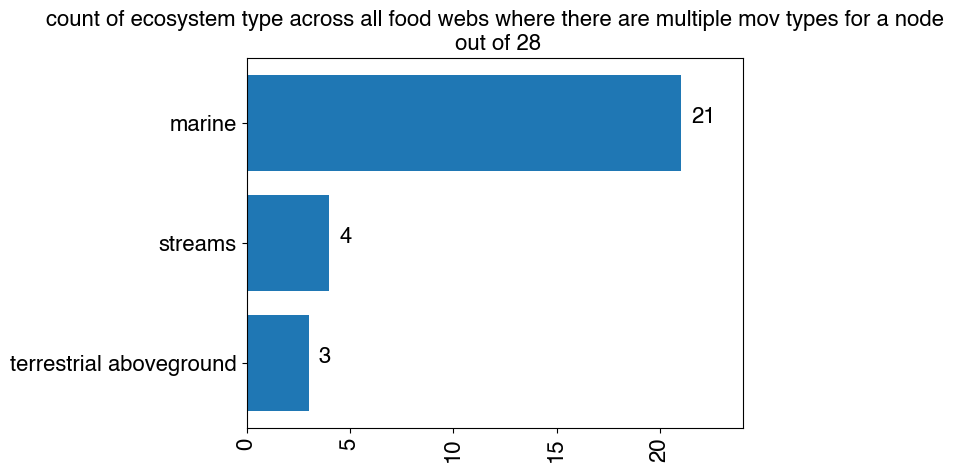

In [15]:
## CELL 13 - Visualization of ecosystem types for food webs with multiple movement type for a node
with open('mov_mult_eco_type.pickle', 'rb') as handle:
    mov_mult_eco_type = pickle.load(handle)
fw_mm = 28

data_processing_helper.sorted_count_plot(mov_mult_eco_type, fw_mm, 3, 0.5,\
            "ecosystem type across all food webs where there are multiple mov types for a node",\
                                         "eco_type_multmov",FONT_SIZE)

In [16]:
# CELL 14 - Resolve conflicts if multiple values listed for mass (take mean) in a fw + note these
# Also save a list of the nodes with missing masses + how many per food web
# Also save objects that will be used to help fill in missing mass values 

with open('node_masses.pickle', 'rb') as handle:
    node_masses = pickle.load(handle)
with open('node_movs_final.pickle', 'rb') as handle:
    node_movs_final = pickle.load(handle)
with open('node_mets_final.pickle', 'rb') as handle:
    node_mets_final = pickle.load(handle)
with open('interaction_records.pickle', 'rb') as handle:
    interaction_records = pickle.load(handle)

ct_mass_conflict = 0
mass_conflict_fw = []
ct_mass_missing = 0
node_mass_final = {}
node_missing_mass = {}
mass_missing_fw = []
fw_ct_mass_missing = {}
mass_conflict_details = {}

# for filling in missing values
unique_nodes_missing_mass = [] 
unique_genus_missing_mass = [] 
# {fw.id: [(met0,mov0), etc.]}
unique_fw_metmov_missing_mass = {}
# {fw.id: [met0, etc], etc}
unique_fw_mets_missing_mass ={}
# {fw.id: [mov0, etc], etc}
unique_fw_movs_missing_mass ={}
unique_mets_missing_mass = []
unique_movs_missing_mass = []

for fw in node_masses:
    node_mass_final[fw] = {}
    node_missing_mass[fw] = []
    if fw not in fw_ct_mass_missing:
        fw_ct_mass_missing[fw] = 0
    for species in node_masses[fw]:
        if len(set(node_masses[fw][species])) > 1:
            ct_mass_conflict+=1
            node_mass_final[fw][species] = np.mean(node_masses[fw][species])
            if fw not in mass_conflict_fw:
                mass_conflict_fw.append(fw)
            if fw not in mass_conflict_details:
                mass_conflict_details[fw] = [species]
            else:
                if species not in mass_conflict_details[fw]:
                    mass_conflict_details[fw].append(species)
        else:
            # one unique value
            if len(node_masses[fw][species]) > 0:
                node_mass_final[fw][species] = np.mean(node_masses[fw][species])
            # empty -- get set up to fill in... 
            else:
                node_missing_mass[fw].append(species)
                
                ct_mass_missing +=1
                fw_ct_mass_missing[fw] +=1
                if fw not in mass_missing_fw:
                    mass_missing_fw.append(fw)
                    
                if species not in unique_nodes_missing_mass:
                    unique_nodes_missing_mass.append(species)
                    
                genus = data_processing_helper.get_genus(species)
                if genus not in unique_genus_missing_mass:
                    unique_genus_missing_mass.append(genus)
                    
                curr_met = node_mets_final[fw][species][0] # checked there are none with multiple
                assert len(node_mets_final[fw][species]) == 1, "unexpected multiple - met"
                curr_mov = node_movs_final[fw][species][0] # checked there are none with multiple
                assert len(node_movs_final[fw][species]) == 1, f"unexpected multiple - mov {node_movs_final[fw][species]}"
                if fw not in unique_fw_metmov_missing_mass:
                    unique_fw_metmov_missing_mass[fw] = [(curr_met,curr_mov)]
                else:
                    if (curr_met, curr_mov) not in unique_fw_metmov_missing_mass[fw]:
                        unique_fw_metmov_missing_mass[fw].append((curr_met,curr_mov))
                if fw not in unique_fw_mets_missing_mass:
                    unique_fw_mets_missing_mass[fw] = [curr_met]
                else:
                    if curr_met not in unique_fw_mets_missing_mass[fw]:
                        unique_fw_mets_missing_mass[fw].append(curr_met)
                if fw not in unique_fw_movs_missing_mass:
                    unique_fw_movs_missing_mass[fw] = [curr_mov]
                else:
                    if curr_mov not in unique_fw_movs_missing_mass[fw]:
                        unique_fw_movs_missing_mass[fw].append(curr_mov)
                if curr_met not in unique_mets_missing_mass:
                    unique_mets_missing_mass.append(curr_met)
                if curr_mov not in unique_movs_missing_mass:
                    unique_movs_missing_mass.append(curr_mov)
                    
print(f"number of nodes with mass conflict in a food web: {ct_mass_conflict}")
print(f"number of fw with a node with a mass conflict: {len(mass_conflict_fw)}")
print(f"number of nodes with mass missing in a food web: {ct_mass_missing}")
print(f"number of unique nodes missing mass: {len(unique_nodes_missing_mass)}")
print(f"number of fw with a node missing mass: {len(mass_missing_fw)}")
print(f"number of unique met missing mass: {len(unique_mets_missing_mass)}")
print(f"number of unique mov missing mass: {len(unique_movs_missing_mass)}")

mass_conflict_eco_type = {}
for fw in mass_conflict_fw:
    eco_type = interaction_records[fw]['ecosystem.type']
    if eco_type not in mass_conflict_eco_type:
        mass_conflict_eco_type[eco_type] = 1
    else:
        mass_conflict_eco_type[eco_type] += 1
        
mass_missing_eco_type = {}
for fw in mass_missing_fw:
    eco_type = interaction_records[fw]['ecosystem.type']
    if eco_type not in mass_missing_eco_type:
        mass_missing_eco_type[eco_type] = 1
    else:
        mass_missing_eco_type[eco_type] += 1
        
with open('mass_conflict_eco_type.pickle', 'wb') as handle:
     pickle.dump(mass_conflict_eco_type, handle)
with open('mass_missing_eco_type.pickle', 'wb') as handle:
     pickle.dump(mass_missing_eco_type, handle)
        
with open('mass_conflict_details.pickle', 'wb') as handle:
     pickle.dump(mass_conflict_details, handle)

with open('node_mass_final.pickle', 'wb') as handle:
     pickle.dump(node_mass_final, handle)
with open('node_missing_mass.pickle', 'wb') as handle:
     pickle.dump(node_missing_mass, handle)
with open('fw_ct_mass_missing.pickle', 'wb') as handle:
     pickle.dump(fw_ct_mass_missing, handle)
        
with open('unique_nodes_missing_mass.pickle', 'wb') as handle:
     pickle.dump(unique_nodes_missing_mass, handle)
with open('unique_genus_missing_mass.pickle', 'wb') as handle:
     pickle.dump(unique_genus_missing_mass, handle)
with open('unique_fw_metmov_missing_mass.pickle', 'wb') as handle:
     pickle.dump(unique_fw_metmov_missing_mass, handle)
with open('unique_fw_mets_missing_mass.pickle', 'wb') as handle:
     pickle.dump(unique_fw_mets_missing_mass, handle)
with open('unique_fw_movs_missing_mass.pickle', 'wb') as handle:
     pickle.dump(unique_fw_movs_missing_mass, handle)
with open('unique_mets_missing_mass.pickle', 'wb') as handle:
     pickle.dump(unique_mets_missing_mass, handle)
with open('unique_movs_missing_mass.pickle', 'wb') as handle:
     pickle.dump(unique_movs_missing_mass, handle)

number of nodes with mass conflict in a food web: 18
number of fw with a node with a mass conflict: 14
number of nodes with mass missing in a food web: 1371
number of unique nodes missing mass: 279
number of fw with a node missing mass: 143
number of unique met missing mass: 8
number of unique mov missing mass: 6


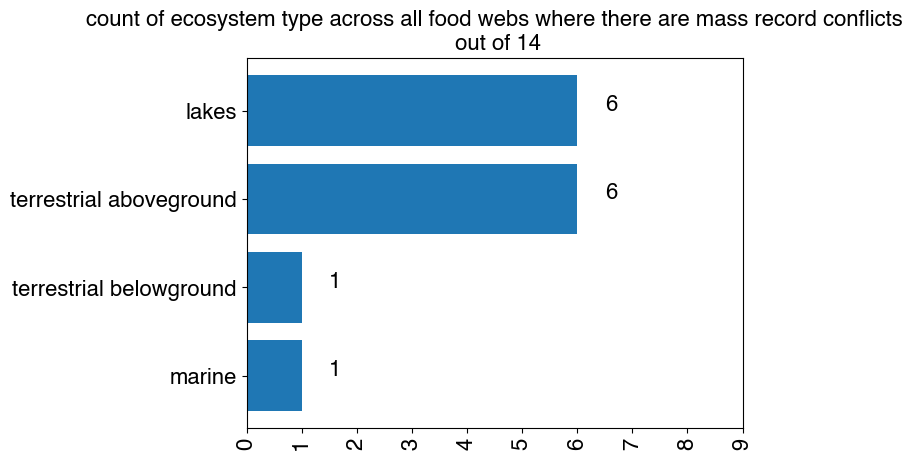

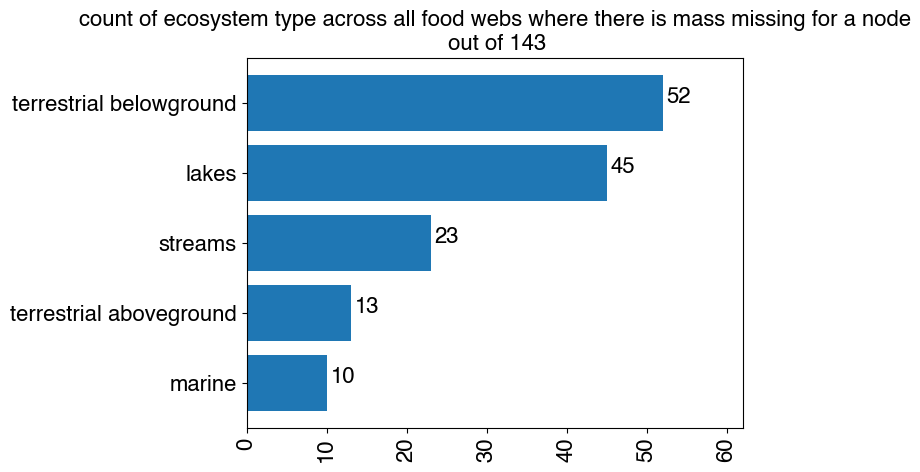

In [17]:
## CELL 15 - Visualization of more counts

# ecosystem types for food webs where there are mass conflicts
with open('mass_conflict_eco_type.pickle', 'rb') as handle:
    mass_conflict_eco_type = pickle.load(handle)
fw_mc = 14

data_processing_helper.sorted_count_plot(mass_conflict_eco_type, fw_mc, 3, 0.5,\
            "ecosystem type across all food webs where there are mass record conflicts",\
                                         "eco_type_massconflict",FONT_SIZE)

# ecosystem types for food webs where there are nodes missing mass 
with open('mass_missing_eco_type.pickle', 'rb') as handle:
    mass_missing_eco_type = pickle.load(handle)
fw_mm = 143
data_processing_helper.sorted_count_plot(mass_missing_eco_type, fw_mm, 10, 0.5,\
            "ecosystem type across all food webs where there is mass missing for a node",\
                                         "eco_type_massmissing",FONT_SIZE)

In [18]:
## Cell 16 - Mass conflict node details
## How many of these are aggregated across life stage or at non-species taxonomic level?
with open('mass_conflict_details.pickle', 'rb') as handle:
    mass_conflict_details = pickle.load(handle)
with open('tax_nodes.pickle', 'rb') as handle:
    tax_nodes = pickle.load(handle)
with open('multilife_details.pickle', 'rb') as handle:
    multilife_details = pickle.load(handle)
mass_conflict_count = 18

print("multi life details")
print(multilife_details)

print(mass_conflict_details)

non_species_ct = 0
multilife_ct = 0
total=0
for fw in mass_conflict_details:
    for species in mass_conflict_details[fw]:
        curr_tax = tax_nodes[species][0]
        if curr_tax != 'species':
            non_species_ct +=1
        if fw in multilife_details and species in multilife_details[fw]:
            print(multilife_details[fw])
            multilife_ct +=1
        total+=1
        
assert total == mass_conflict_count, "incorrect length"

print(f"number of these aggregated across multiple lifestages: {multilife_ct}")
print(f"percent of these aggregated across multiple lifestages: {multilife_ct/mass_conflict_count*100}")
print(f"number of these at non-species taxonomic level: {non_species_ct}")
print(f"percent of these at non-species taxonomic level: {non_species_ct/mass_conflict_count*100}")

multi life details
{}
{'Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1': ['Psychodidae_adults', 'Marpissa radiata_NA', 'Psychodidae_larvae', 'Antistea elegans_NA'], 'Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown2': ['Psychodidae_adults'], 'Grand Caricaie  marsh dominated by Cladietum marisci, not mown  ClControl1': ['Antistea elegans_NA'], 'Grand Caricaie  marsh dominated by Cladietum marisci, not mown  ClControl2': ['Antistea elegans_NA'], 'Grand Caricaie  marsh dominated by Schoenus nigricans, not mown  ScControl1 ': ['Psychodidae_adults', 'Philodromidae_NA'], 'Grand Caricaie  marsh dominated by Schoenus nigricans, not mown  ScControl2 ': ['Antistea elegans_NA'], 'Kongsfjorden': ['Calanus finnmarchicus_NA'], 'Connera lake': ['Salvelinus fontinalis small_NA'], 'Fawn lake': ['Notemigonus crysoleucas_NA'], 'High pond': ['Salvelinus fontinalis_NA'], 'Hoel lake': ['Salvelinus namaycush_NA'], 'Lost Lake': ['Salvelinus fontinalis_NA'], 'Safford Lake

In [19]:
## CELL 17 - Record + save details of missing mass values  (web, eco type, tax level, other traits)
f = open(DATA_FILE,'r')
reader = csv.reader(f)
next(reader)

with open('node_missing_mass.pickle', 'rb') as handle:
    node_missing_mass = pickle.load(handle)
with open('node_movs_final.pickle', 'rb') as handle:
    node_movs_final = pickle.load(handle)
with open('node_mets_final.pickle', 'rb') as handle:
    node_mets_final = pickle.load(handle)
with open('tax_nodes.pickle', 'rb') as handle:
    tax_nodes = pickle.load(handle)

# list of lists (rows)
# for taxonomy level, movement type, and metabolic type use the final ones 
# [food.web, eco.type, node, genus, taxonomy.level, [mov.types], [met.types]] 
missing_mass_details = []
missing_mass_added = [] # keep track of unique (fw, node) pairs already added 

mets_mult = 0
movs_mult = 0

for row in reader: # Looping through interaction records
    
    fw = row[FW_NAME_INDEX] # foodweb.name
    eco_type = row[ECOTYPE_INDEX] # ecosystem.type
    con = row[CON_INDEX]  # con.taxonomy
    res = row[RES_INDEX] # res.taxonomy
    
    con_ls = row[CON_LS_INDEX] # con.lifestage
    res_ls = row[RES_LS_INDEX] # con.lifestage
    
    con = f'{con}_{con_ls}'
    res = f'{res}_{res_ls}'
    
    if fw in node_missing_mass:
        if con in node_missing_mass[fw]:
            if (fw, con) not in missing_mass_added:
                genus = data_processing_helper.get_genus(con)
                con_tax = tax_nodes[con][0] # con.taxonomy.level
                mov_type = node_movs_final[fw][con]
                if len(mov_type) > 1:
                    movs_mult += 1
                met_type = node_mets_final[fw][con]
                if len(met_type) > 1:
                    mets_mult += 1
                new_row = [fw, eco_type, con, genus, con_tax, mov_type[0], met_type[0]]
                missing_mass_added.append((fw, con))
                missing_mass_details.append(new_row)
        if res in node_missing_mass[fw]:
            if (fw, res) not in missing_mass_added:
                genus = data_processing_helper.get_genus(res)
                res_tax = tax_nodes[res][0] # res.taxonomy.level
                mov_type = node_movs_final[fw][res]
                if len(mov_type) > 1:
                    movs_mult += 1
                met_type = node_mets_final[fw][res]
                if len(met_type) > 1:
                    mets_mult += 1
                new_row = [fw, eco_type, res, genus, res_tax, mov_type[0], met_type[0]]
                missing_mass_added.append((fw, res))
                missing_mass_details.append(new_row)
                
print(len(missing_mass_details))

print(f"Needed to chose 1 met for the node missing mass - {mets_mult}")
print(f"Needed to chose 1 mov for the node missing mass - {movs_mult}")
    
with open('missing_mass_details.pickle', 'wb') as handle:
     pickle.dump(missing_mass_details, handle)
f.close()

1371
Needed to chose 1 met for the node missing mass - 0
Needed to chose 1 mov for the node missing mass - 0


In [20]:
# CELL 18 - Collect data used to fill in missing mass values

with open('node_mass_final.pickle', 'rb') as handle:
    node_mass_final = pickle.load(handle)
    
with open('node_movs_final.pickle', 'rb') as handle:
    node_movs_final = pickle.load(handle)
with open('node_mets_final.pickle', 'rb') as handle:
    node_mets_final = pickle.load(handle)
    
with open('unique_nodes_missing_mass.pickle', 'rb') as handle:
    unique_nodes_missing_mass = pickle.load(handle)
with open('unique_genus_missing_mass.pickle', 'rb') as handle:
    unique_genus_missing_mass = pickle.load(handle)
with open('unique_fw_metmov_missing_mass.pickle', 'rb') as handle:
    unique_fw_metmov_missing_mass = pickle.load(handle)
with open('unique_fw_mets_missing_mass.pickle', 'rb') as handle:
    unique_fw_mets_missing_mass = pickle.load(handle)
with open('unique_fw_movs_missing_mass.pickle', 'rb') as handle:
    unique_fw_movs_missing_mass = pickle.load(handle)
with open('unique_mets_missing_mass.pickle', 'rb') as handle:
    unique_mets_missing_mass = pickle.load(handle)
with open('unique_movs_missing_mass.pickle', 'rb') as handle:
    unique_movs_missing_mass = pickle.load(handle)

same_node_other_webs = {} # {species: [masses]}
same_genus_other_webs = {} # {genus: [masses]}
same_metmov_same_web = {} # {fw: {(met,mov): [masses]}}
same_met_same_web = {} # {fw: {met: [masses]}}
same_mov_same_web = {} # {fw: {mov: [masses]}}
same_met_other_webs = {} # {met0: [masses], etc}
same_mov_other_webs = {} # {mov0: [masses], etc}

for fw in node_mass_final:
    for node in node_mass_final[fw]:
        curr_mass = node_mass_final[fw][node]
        if node in unique_nodes_missing_mass:
            if node not in same_node_other_webs:
                same_node_other_webs[node] = [curr_mass]
            else:
                same_node_other_webs[node].append(curr_mass)
        genus = data_processing_helper.get_genus(node)
        if genus in unique_genus_missing_mass:
            if genus not in same_genus_other_webs:
                same_genus_other_webs[genus] = [curr_mass]
            else:
                same_genus_other_webs[genus].append(curr_mass)
        for curr_met in node_mets_final[fw][node]:
            if curr_met in unique_mets_missing_mass:
                if curr_met not in same_met_other_webs:
                    same_met_other_webs[curr_met] = [curr_mass]
                else:
                    same_met_other_webs[curr_met].append(curr_mass)
        for curr_mov in node_movs_final[fw][node]:
            if curr_mov in unique_movs_missing_mass:
                if curr_mov not in same_mov_other_webs:
                    same_mov_other_webs[curr_mov] = [curr_mass]
                else:
                    same_mov_other_webs[curr_mov].append(curr_mass)
        for curr_met in node_mets_final[fw][node]: # check all of them for finding similar nodes
            for curr_mov in node_movs_final[fw][node]:
                if fw in unique_fw_metmov_missing_mass:
                    if (curr_met, curr_mov) in unique_fw_metmov_missing_mass[fw]:
                        if fw not in same_metmov_same_web:
                            same_metmov_same_web[fw] = {(curr_met, curr_mov): [curr_mass]}
                        else:
                            if (curr_met, curr_mov) in same_metmov_same_web[fw]:
                                same_metmov_same_web[fw][(curr_met, curr_mov)].append(curr_mass)
                            else:
                                same_metmov_same_web[fw][(curr_met, curr_mov)] = [curr_mass]
                if fw in unique_fw_mets_missing_mass:
                    if curr_met in unique_fw_mets_missing_mass[fw]:
                        if fw not in same_met_same_web:
                            same_met_same_web[fw] = {curr_met: [curr_mass]}
                        else:
                            if curr_met in same_met_same_web[fw]:
                                same_met_same_web[fw][curr_met].append(curr_mass)
                            else:
                                same_met_same_web[fw][curr_met] = [curr_mass]
                if fw in unique_fw_movs_missing_mass:
                    if curr_mov in unique_fw_movs_missing_mass[fw]:
                        if fw not in same_mov_same_web:
                            same_mov_same_web[fw] = {curr_mov: [curr_mass]}
                        else:
                            if curr_mov in same_mov_same_web[fw]:
                                same_mov_same_web[fw][curr_mov].append(curr_mass)
                            else:
                                same_mov_same_web[fw][curr_mov] = [curr_mass]

same_ct1=0
for fw in same_metmov_same_web:
    for node in same_metmov_same_web[fw]:
        same_ct1+=1

same_ct2=0
for fw in same_met_same_web:
    for node in same_met_same_web[fw]:
        same_ct2+=1

same_ct3=0
for fw in same_mov_same_web:
    for node in same_mov_same_web[fw]:
        same_ct3+=1
        
print(f"Found mass records in other webs (# nodes) -- {len(same_node_other_webs.keys())}")
print(f"Found mass records in other webs (# genuses) -- {len(same_genus_other_webs.keys())}")
print(f"Found mass records in same webs (# fw / met / mov) -- {same_ct1}")
print(f"Found mass records in same webs (# fw / met) -- {same_ct2}")
print(f"Found mass records in same webs (# fw / mov) -- {same_ct3}")
print(f"Found mass records in other webs (# met) -- {len(same_met_other_webs.keys())}")
print(f"Found mass records in other webs (# mov) -- {len(same_mov_other_webs.keys())}")

with open('same_node_other_webs.pickle', 'wb') as handle:
     pickle.dump(same_node_other_webs, handle)
with open('same_genus_other_webs.pickle', 'wb') as handle:
     pickle.dump(same_genus_other_webs, handle)
with open('same_metmov_same_web.pickle', 'wb') as handle:
     pickle.dump(same_metmov_same_web, handle)
with open('same_met_same_web.pickle', 'wb') as handle:
     pickle.dump(same_met_same_web, handle)
with open('same_mov_same_web.pickle', 'wb') as handle:
     pickle.dump(same_mov_same_web, handle)
with open('same_met_other_webs.pickle', 'wb') as handle:
     pickle.dump(same_met_other_webs, handle)
with open('same_mov_other_webs.pickle', 'wb') as handle:
     pickle.dump(same_mov_other_webs, handle)

Found mass records in other webs (# nodes) -- 25
Found mass records in other webs (# genuses) -- 44
Found mass records in same webs (# fw / met / mov) -- 65
Found mass records in same webs (# fw / met) -- 77
Found mass records in same webs (# fw / mov) -- 120
Found mass records in other webs (# met) -- 5
Found mass records in other webs (# mov) -- 5


In [21]:
## CELL 19 - Fill in missing mass values + record these changes
with open('node_missing_mass.pickle', 'rb') as handle:
    node_missing_mass = pickle.load(handle)
with open('tax_nodes.pickle', 'rb') as handle:
    tax_nodes = pickle.load(handle)
with open('node_mass_final.pickle', 'rb') as handle:
    node_mass_final = pickle.load(handle)
    
with open('node_movs_final.pickle', 'rb') as handle:
    node_movs_final = pickle.load(handle)
with open('node_mets_final.pickle', 'rb') as handle:
    node_mets_final = pickle.load(handle)
with open('same_node_other_webs.pickle', 'rb') as handle:
    same_node_other_webs = pickle.load(handle)
with open('same_genus_other_webs.pickle', 'rb') as handle:
    same_genus_other_webs = pickle.load(handle)
with open('same_metmov_same_web.pickle', 'rb') as handle:
    same_metmov_same_web = pickle.load(handle)
with open('same_met_same_web.pickle', 'rb') as handle:
    same_met_same_web = pickle.load(handle)
with open('same_mov_same_web.pickle', 'rb') as handle:
    same_mov_same_web = pickle.load(handle)
with open('same_met_other_webs.pickle', 'rb') as handle:
    same_met_other_webs = pickle.load(handle)
with open('same_mov_other_webs.pickle', 'rb') as handle:
    same_mov_other_webs = pickle.load(handle)
        
# record for each food web and node combo the mass value to fill + why (mass, how)
# how:
# 0 - mean of same species other webs
# 1 - mean of same genus other webs
# 2 - mean of the same metabolic type and movement type in the same food web
# 3 - mean of the same metabolic type in the same food web 
# 4 - mean of the same movement type in the same food web 
# 5 - mean of the same metabolic type in other webs 
# 6 - mean of the same movement type in other webs 
missing_mass_filled = {}
ct_un = 0
ct_0 = 0
ct_1 = 0
ct_2 = 0
ct_3 = 0
ct_4 = 0
ct_5 = 0
ct_6 = 0
p = False
for fw in node_missing_mass:
    missing_mass_filled[fw] = {}
    for node in node_missing_mass[fw]:
        curr_tax = tax_nodes[node][0]
        if curr_tax =="unclassified" and node_mets_final[fw][node][0] == "invertebrate":
            print(f"Unclassified tax and invertebrate: {fw}  ----    {node}")
        if curr_tax =="unclassified" and node_mets_final[fw][node][0] != "invertebrate":
            missing_mass_filled[fw][node] = (np.min(list(node_mass_final[fw].values())), 'unclassified')
            ct_un +=1
        else:
            if node in same_node_other_webs:
                mean_m = np.mean(same_node_other_webs[node])
                missing_mass_filled[fw][node] = (mean_m, 0)
                ct_0+=1
            else:
                genus = data_processing_helper.get_genus(node)
                if genus in same_genus_other_webs:
                    mean_m = np.mean(same_genus_other_webs[genus])
                    missing_mass_filled[fw][node] = (mean_m, 1)
                    ct_1+=1
                else:
                    curr_met = node_mets_final[fw][node][0]
                    curr_mov = node_movs_final[fw][node][0]
                    if fw in same_metmov_same_web and (curr_met, curr_mov) in same_metmov_same_web[fw]:
                        mean_m = np.mean(same_metmov_same_web[fw][(curr_met, curr_mov)])
                        missing_mass_filled[fw][node] = (mean_m, 2)
                        ct_2+=1
                    else:
                        if fw in same_met_same_web and curr_met in same_met_same_web[fw]:
                            mean_m = np.mean(same_met_same_web[fw][curr_met])
                            missing_mass_filled[fw][node] = (mean_m, 3)
                            ct_3+=1
                        else:
                            if fw in same_mov_same_web and curr_mov in same_mov_same_web[fw]:
                                mean_m = np.mean(same_mov_same_web[fw][curr_mov])
                                missing_mass_filled[fw][node] = (mean_m, 4)
                                ct_4 +=1
                            else:
                                if curr_met in same_met_other_webs:
                                    mean_m = np.mean(same_met_other_webs[curr_met])
                                    missing_mass_filled[fw][node] = (mean_m, 5)
                                    ct_5 +=1
                                else:
                                    if curr_mov in same_mov_other_webs:
                                        mean_m = np.mean(same_mov_other_webs[curr_mov])
                                        missing_mass_filled[fw][node] = (mean_m, 6)
                                        ct_6 +=1
                                    else:
                                        print(f"didn't fill in - {node}")

print("")
print("")
print(f"Replaced unclassified -- {ct_un}")
print(f"Remaining -- {1371-ct_un}")
print(f"Replaced mean same species other webs -- {ct_0}")
print(f"Replaced mean same genus other webs-- {ct_1}")
print(f"Replaced mean same metabolic type and movement type, same web -- {ct_2}")
print(f"Replaced mean same metabolic type, same web -- {ct_3}")
print(f"Replaced mean same movement type, same web -- {ct_4}")
print(f"Replaced mean same metabolic type, other webs -- {ct_5}")
print(f"Replaced mean same movement type, other webs -- {ct_6}")
print(f"Remaining -- {1371-(ct_un+ct_0+ct_1+ct_2+ct_3+ct_4+ct_5+ct_6)}")

filled_ct = 0
for fw in missing_mass_filled:
    for node in missing_mass_filled[fw]:
        filled_ct+=1
print(f"Number filled - {filled_ct}")

with open('missing_mass_filled.pickle', 'wb') as handle:
     pickle.dump(missing_mass_filled, handle)

Unclassified tax and invertebrate: Chesapeake Bay  ----    Trichoptera_larvae
Unclassified tax and invertebrate: Carpinteria  ----    unk a/sm meso_cercaria
Unclassified tax and invertebrate: Carpinteria  ----    unk c_cercaria
Unclassified tax and invertebrate: Carpinteria  ----    Trematode_cercaria
Unclassified tax and invertebrate: Lake Malawi  ----    Chaoborus edulis_larvae
Unclassified tax and invertebrate: Lake Malawi  ----    Zooplankton_adults
Unclassified tax and invertebrate: Blackrock Stream  ----    Terrestrial Invertebrates_NA
Unclassified tax and invertebrate: Broad Stream  ----    Terrestrial invertebrates_NA
Unclassified tax and invertebrate: Canton Creek  ----    Terrestrial invertebrates_NA
Unclassified tax and invertebrate: Dempsters Stream  ----    Terrestial invertebrates_NA
Unclassified tax and invertebrate: German Creek  ----    Terrestrial invertebrates_NA
Unclassified tax and invertebrate: Healy Creek  ----    Terrestrial invertebrates_NA
Unclassified tax and

In [22]:
## CELL 20 -  Output final CSV about missing mass node details and how they were filled in 
with open('missing_mass_details.pickle', 'rb') as handle:
    missing_mass_details = pickle.load(handle)
with open('missing_mass_filled.pickle', 'rb') as handle:
    missing_mass_filled = pickle.load(handle)
    
print(len(missing_mass_details))
print(missing_mass_details[0])

unique_unclassified = {}
missing_mass_file = []
for row in missing_mass_details:
    fw = row[0]
    node = row[2]
    replace_record = missing_mass_filled[fw][node]
    new_mass = replace_record[0]
    replace_method = replace_record[1]
    if replace_method != "unclassified":
        method_vector = [0]*7
        method_vector[replace_method] = 1
        new_row = row + [new_mass] + method_vector
        missing_mass_file.append(new_row)
    else:
        unique_combo = (node,row[5],row[6])
        if unique_combo not in unique_unclassified:
            unique_unclassified[unique_combo] = 1
        else:
            unique_unclassified[unique_combo] +=1

        
details_cols = ['food.web', 'eco.type', 'node', 'genus', 'taxonomy.level', 'mov.type', 'met.type']
replace_cols = ['new.mass', 'species.other', 'genus.other', 'met.mov.same', 'met.same', 'mov.same', 'met.other', 'mov.other']
df = pd.DataFrame(missing_mass_file, columns = details_cols + replace_cols) 
df.to_csv('missing_mass_file.csv')

print(len(unique_unclassified))
#print(unique_unclassified)
unique_unclassified_new = {}
ct = 0
for key in unique_unclassified:
    unique_unclassified_new[ct] = [key[0],key[1],key[2],unique_unclassified[key]]
    ct+=1
df_un = pd.DataFrame.from_dict(unique_unclassified_new, orient="index", columns=["node_name","mov.type","met.type","num_food_webs"])
df_un.to_csv('missing_mass_file_unclassified.csv')

1371
['Ythan Estuary', 'marine', 'POM (detritus)_NA', 'POM', 'unclassified', 'other_nonliving', 'detritus']
51


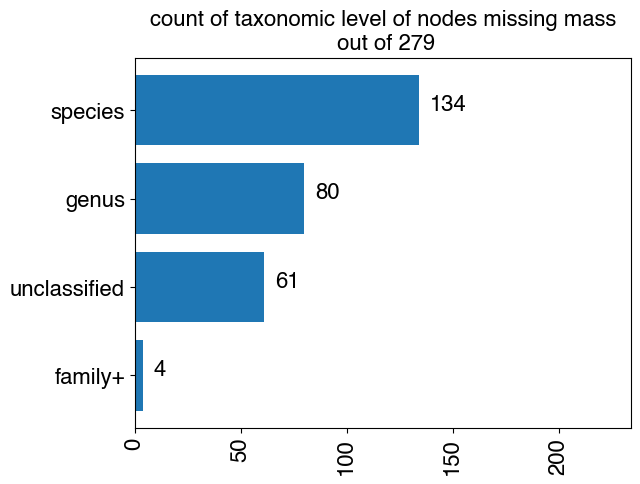

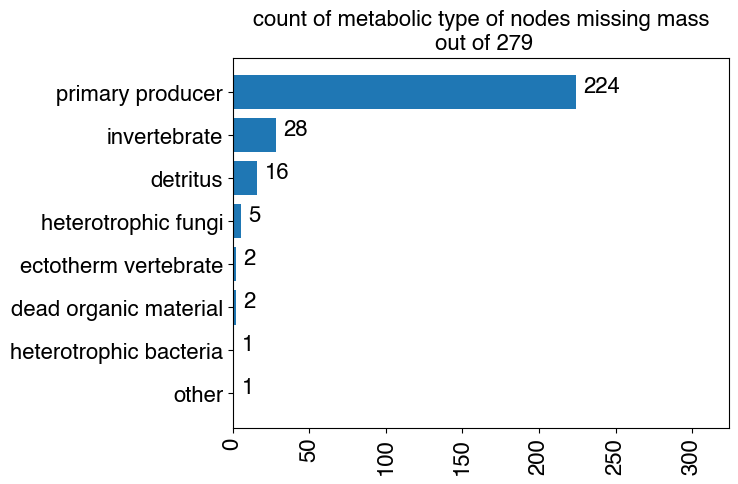

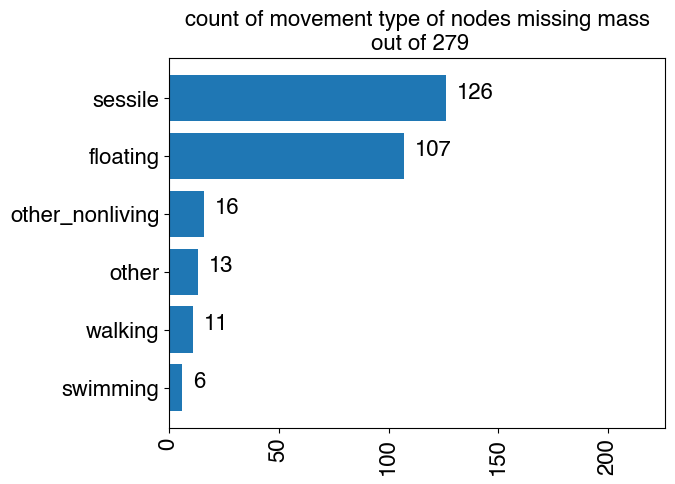

In [23]:
## CELL 21 - Count plots for the unique nodes missing mass
with open('missing_mass_details.pickle', 'rb') as handle:
    missing_mass_details = pickle.load(handle)
uni_num = 279 # Number of unique nodes missing mass

mm_taxes = {}
node_taxes = {}
mm_mets = {}
node_mets = {}
num_diff = 0
mm_movs = {}
node_movs = {}
num_diff2 = 0
for row in missing_mass_details:
    node_curr = row[2]
    tax_curr = row[4]
    mov_curr = row[5]
    met_curr = row[6]
    if node_curr not in node_taxes:
        node_taxes[node_curr] = tax_curr
        if tax_curr not in mm_taxes:
            mm_taxes[tax_curr] = 1
        else:
            mm_taxes[tax_curr] += 1
    else:
        if tax_curr != node_taxes[node_curr]:
            print(f"value is different in different webs - {node_curr} - {tax_curr} - {node_taxes[node_curr]}")
    if node_curr not in node_mets:
        node_mets[node_curr] = [met_curr]
        if met_curr not in mm_mets:
            mm_mets[met_curr] = 1
        else:
            mm_mets[met_curr] += 1
    else:
        if met_curr not in node_mets[node_curr]:
            print(f"value is different in different webs - {node_curr} - {met_curr} - {node_mets[node_curr]}")
            node_mets[node_curr].append(met_curr)
            mm_mets[met_curr] +=1
            num_diff +=1
    if node_curr not in node_movs:
        node_movs[node_curr] = [mov_curr]
        if mov_curr not in mm_movs:
            mm_movs[mov_curr] = 1
        else:
            mm_movs[mov_curr] += 1
    else:
        if mov_curr not in node_movs[node_curr]:
            print(f"value is different in different webs - {node_curr} - {mov_curr} - {node_movs[node_curr]}")
            node_movs[node_curr].append(mov_curr)
            if mov_curr not in mm_movs:
                mm_movs[mov_curr] = 1
            else:
                mm_movs[mov_curr] +=1
            num_diff2 +=1
            
# Report details about the (unique) nodes with missing mass - taxonomic level 
data_processing_helper.sorted_count_plot(mm_taxes, uni_num, 100, 5,\
            "taxonomic level of nodes missing mass","missing_mass_tax_level",FONT_SIZE)
# Report details about the (unique) nodes with missing mass - metabolic type 
data_processing_helper.sorted_count_plot(mm_mets, uni_num+num_diff, 100, 5,\
            "metabolic type of nodes missing mass","missing_mass_met_type",FONT_SIZE)
# Report details about the (unique) nodes with missing mass - movement type
data_processing_helper.sorted_count_plot(mm_movs, uni_num+num_diff2, 100, 5,\
            "movement type of nodes missing mass","missing_mass_mov_type",FONT_SIZE)

83
83


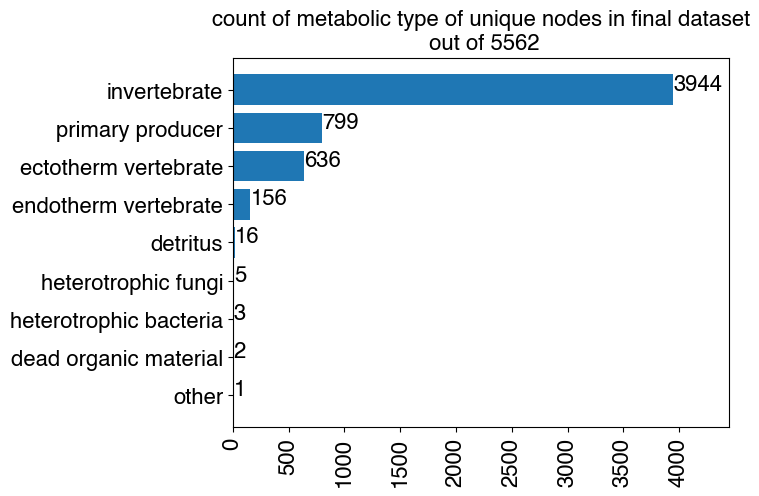

number different for movement - 83


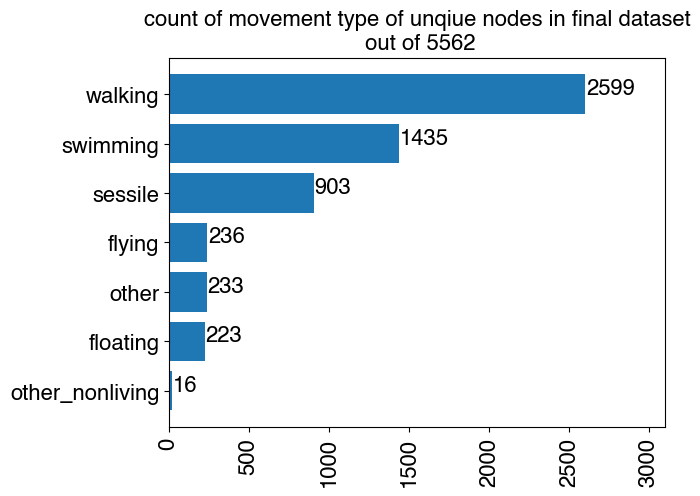

In [24]:
# Cell 22 - Count plots about metabolic and movement type across the final dataset

with open('node_mets_final.pickle', 'rb') as handle:
    node_mets_final = pickle.load(handle)
with open('node_movs_final.pickle', 'rb') as handle:
    node_movs_final = pickle.load(handle)
uni_num = 5562 # Number of unique nodes in the final dataset

mm_mets = {}
node_mets = {}
num_diff = 0
mm_movs = {}
node_movs = {}
num_diff2 = 0
mov_diff_list = []
for fw in node_mets_final:
    for node in node_mets_final[fw]:
        mets_curr = node_mets_final[fw][node]  
        movs_curr = node_movs_final[fw][node]
        for met_curr in mets_curr:
            if node not in node_mets:
                node_mets[node] = [met_curr]
                if met_curr not in mm_mets:
                    mm_mets[met_curr] = 1
                else:
                    mm_mets[met_curr] += 1
            else:
                if met_curr not in node_mets[node]:
                    print(f"value is different (same or diff web) - {node} - {met_curr} - {node_mets[node]}")
                    node_mets[node].append(met_curr)
                    mm_mets[met_curr] += 1
                    num_diff += 1
        for mov_curr in movs_curr:
            if node not in node_movs:
                node_movs[node] = [mov_curr]
                if mov_curr not in mm_movs:
                    mm_movs[mov_curr] = 1
                else:
                    mm_movs[mov_curr] += 1
            else:
                if mov_curr not in node_movs[node]:
                    node_movs[node].append(mov_curr)
                    if mov_curr in mm_movs:
                        mm_movs[mov_curr] += 1
                    else:
                        mm_movs[mov_curr] = 1
                    num_diff2 += 1
                    mov_diff_list.append(node)

mov_diff_details = {}
for fw in node_movs_final:
    for node in node_movs_final[fw]:
        movs_curr = node_movs_final[fw][node]
        for mov_curr in movs_curr:
            if node in mov_diff_list:
                if node not in mov_diff_details:
                    mov_diff_details[node] = [(fw, mov_curr)]
                else:
                    mov_diff_details[node].append((fw, mov_curr))

ctt = 0
rnning = 0
for item in mov_diff_details:
    num_unique = len(set([y for (x,y) in mov_diff_details[item]]))
    #print(f"{ctt} num_unique:{num_unique} {item} {mov_diff_details[item]} \n")
    rnning = rnning + num_unique-1
    ctt = ctt+1
print(rnning)
print(num_diff2)
                 
# Report details about the metabolic types across unique nodes
data_processing_helper.sorted_count_plot(mm_mets, uni_num+num_diff, 500, 5,\
            "metabolic type of unique nodes in final dataset","all_nodes_met_type",FONT_SIZE)
# Report details about the movement types across unique nodes
print(f"number different for movement - {num_diff2}")
data_processing_helper.sorted_count_plot(mm_movs, uni_num, 500, 5,\
            "movement type of unqiue nodes in final dataset","all_nodes_mov_type",FONT_SIZE)

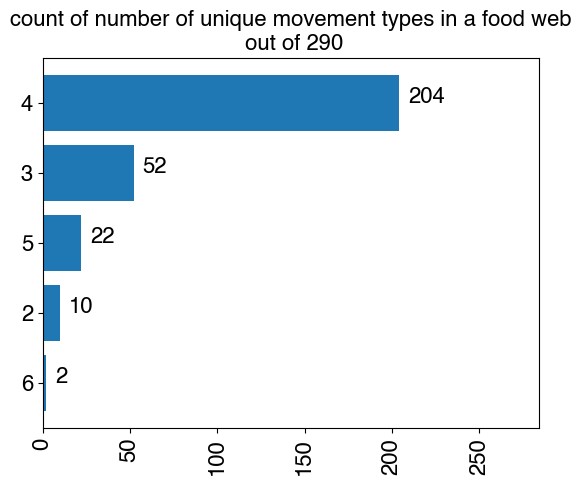

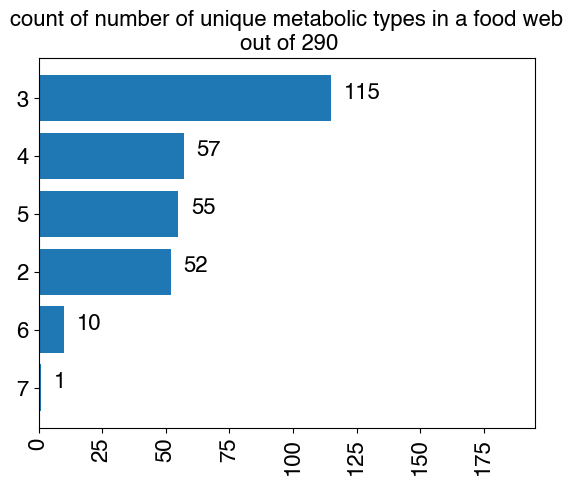

In [25]:
## CELL 23 - Report information about how the set of movement and metabolic type values vary across the datasets
with open('node_movs_final.pickle', 'rb') as handle:
    node_movs_final = pickle.load(handle)
with open('node_mets_final.pickle', 'rb') as handle:
    node_mets_final = pickle.load(handle)
fw_num = 290
    
fw_movs = {}
for fw in node_movs_final:
    fw_movs[fw] = []
    for node in node_movs_final[fw]:
        curr_movs = node_movs_final[fw][node]
        for curr_mov in curr_movs:
            if curr_mov not in fw_movs[fw]:
                fw_movs[fw].append(curr_mov)

fw_mets = {}
for fw in node_mets_final:
    fw_mets[fw] = []
    for node in node_mets_final[fw]:
        curr_mets = node_mets_final[fw][node]
        for curr_met in curr_mets:
            if curr_met not in fw_mets[fw]:
                fw_mets[fw].append(curr_met)
                
fw_mov_cts = {}
for fw in fw_movs:
    curr_ct = len(fw_movs[fw])
    if curr_ct in fw_mov_cts:
        fw_mov_cts[curr_ct] += 1
    else:
        fw_mov_cts[curr_ct] = 1
        
fw_met_cts = {}
for fw in fw_mets:
    curr_ct = len(fw_mets[fw])
    if curr_ct in fw_met_cts:
        fw_met_cts[curr_ct] += 1
    else:
        fw_met_cts[curr_ct] = 1
                
# Report details about the number of metabolic types across food webs
data_processing_helper.sorted_count_plot(fw_mov_cts, fw_num, 80, 5,\
            "number of unique movement types in a food web","fw_mov_type_ct",FONT_SIZE)
# Report details about the number of movement types across food webs
data_processing_helper.sorted_count_plot(fw_met_cts, fw_num , 80, 5,\
            "number of unique metabolic types in a food web","fw_met_type_ct",FONT_SIZE)

# Also use these later
with open('fw_movs.pickle', 'wb') as handle:
     pickle.dump(fw_movs, handle)
with open('fw_mets.pickle', 'wb') as handle:
     pickle.dump(fw_mets, handle)

max -- Kongsfjorden Balaenoptera acutorostrata_NA
min -- Lough Hyne Bacteria_NA
maximum mass: 52395350.0
minimum mass: 6.8e-21
median mass: 0.00049746
mean mass: 7954.161539279503
number under 1: 17127
number over 1: 1950


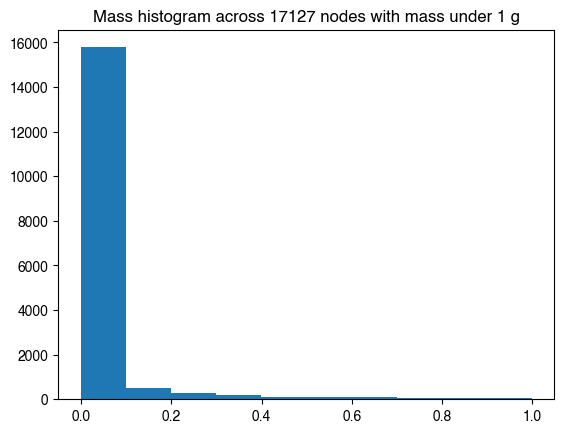

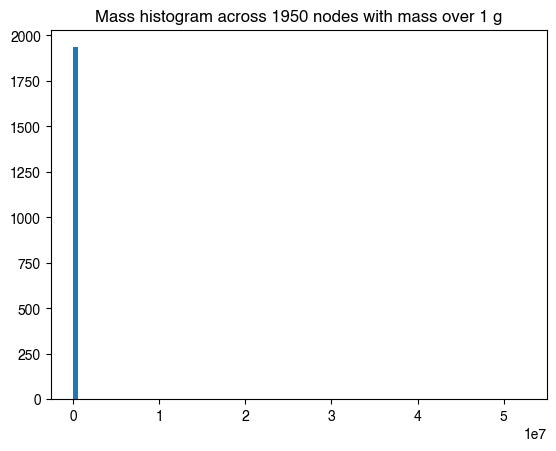

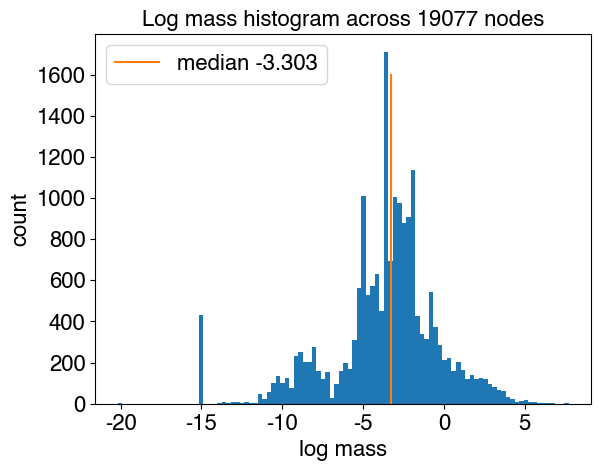

In [26]:
## Cell 24 -- Overall mass distribution

with open('node_mass_final.pickle', 'rb') as handle:
    node_mass_final = pickle.load(handle)
with open('missing_mass_filled.pickle', 'rb') as handle:
    missing_mass_filled = pickle.load(handle)
node_num = 19077 # number of overall nodes in the final dataset

all_masses = []
under_1 = []
over_1 = []
over_100 = []
node_ct = 0 
log_masses = []
for fw in node_mass_final:
    for species in node_mass_final[fw]:
        mass_final = node_mass_final[fw][species]
        all_masses.append(mass_final)
        log_masses.append(math.log10(mass_final))
        node_ct += 1
        if mass_final < 1:
            under_1.append(mass_final)
            if mass_final == 6.8e-21:
                print(f'min -- {fw} {species}')
        else:
            over_1.append(mass_final)
            if mass_final == 52395350.0:
                print(f'max -- {fw} {species}')
        if mass_final > 100:
            over_100.append(mass_final)
    if fw in missing_mass_filled:
        for species in missing_mass_filled[fw]:
            mass_final = missing_mass_filled[fw][species][0]
            all_masses.append(mass_final)
            log_masses.append(math.log10(mass_final))
            node_ct += 1
            if mass_final < 1:
                under_1.append(mass_final)
            else:
                over_1.append(mass_final)
            if mass_final > 100:
                over_100.append(mass_final)
assert len(all_masses) == node_num, 'missing nodes'
assert len(under_1+over_1) == node_num, 'missing nodes 2'

print(f"maximum mass: {max(all_masses)}")
print(f"minimum mass: {min(all_masses)}")
print(f"median mass: {np.median(all_masses)}")
print(f"mean mass: {np.mean(all_masses)}")

print(f"number under 1: {len(under_1)}")
print(f"number over 1: {len(over_1)}")

plt.title(f"Mass histogram across {len(under_1)} nodes with mass under 1 g")
plt.hist(under_1)
plt.savefig('under1_masses_histogram.pdf',dpi=1000,bbox_inches='tight')
plt.show()

plt.title(f"Mass histogram across {len(over_1)} nodes with mass over 1 g")
plt.hist(over_1, bins=100)
plt.savefig('over1_masses_histogram.pdf',dpi=1000,bbox_inches='tight')
plt.show()

plt.title(f"Log mass histogram across {len(log_masses)} nodes",fontsize=FONT_SIZE)
plt.hist(log_masses, bins=100)
#plt.plot([math.log10(0.000228)]*2,[0,1600],label='missing unclassified replacement value')
plt.plot([np.median(log_masses)]*2,[0,1600],label=f'median {np.round(np.median(log_masses),3)}')
plt.xlabel('log mass',fontsize=FONT_SIZE)
plt.ylabel('count',fontsize=FONT_SIZE)
plt.rcParams['axes.unicode_minus'] = False
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.legend(fontsize=FONT_SIZE)
plt.savefig('all_log_masses_histogram.pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [27]:
## CELL 25 - Save all the details (final interactions and traits) to network files
with open('interactions_final.pickle', 'rb') as handle:
    interactions_final = pickle.load(handle)
with open('node_mass_final.pickle', 'rb') as handle:
    node_mass_final = pickle.load(handle)
with open('missing_mass_filled.pickle', 'rb') as handle:
    missing_mass_filled = pickle.load(handle)
with open('node_movs_final.pickle', 'rb') as handle:
    node_movs_final = pickle.load(handle)
with open('node_mets_final.pickle', 'rb') as handle:
    node_mets_final = pickle.load(handle)
with open('fw_movs.pickle', 'rb') as handle:
    fw_movs = pickle.load(handle)
with open('fw_mets.pickle', 'rb') as handle:
    fw_mets = pickle.load(handle)
    
def write_row_text(file, row):
    str_write = row[0]
    for i in range (1, len(row)):
        el = row[i]
        str_write = f"{str_write} {el}"
    str_write = f"{str_write}\n"
    file.write(str_write)

def get_vector(attr_inds, attr_h):
    vect = []
    for i in attr_h:
        if i in attr_inds:
            vect.append(1)
        else:
            vect.append(0)
    return(vect)

folder_shorter_names = {'Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1': 'Grand Caricaie Clmown1',\
    'Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown2': 'Grand Caricaie Clmown2',\
    'Grand Caricaie  marsh dominated by Cladietum marisci, not mown  ClControl1':'Grand Caricaie ClControl1',\
    'Grand Caricaie  marsh dominated by Cladietum marisci, not mown  ClControl2': 'Grand Caricaie ClControl2',\
    'Grand Caricaie  marsh dominated by Schoenus nigricans, mown  Scmown1 ': 'Grand Caricaie Scmown1',\
    'Grand Caricaie  marsh dominated by Schoenus nigricans, mown  Scmown2 ': 'Grand Caricaie Scmown2',\
    'Grand Caricaie  marsh dominated by Schoenus nigricans, not mown  ScControl1 ': 'Grand Caricaie ScControl1',\
    'Grand Caricaie  marsh dominated by Schoenus nigricans, not mown  ScControl2 ': 'Grand Caricaie ScControl2'}
    
fw_id = 0 # unique numeric id for each food web
fw_ids = {}
node_ids = {} # fw : {node: id}
node_ids_rev = {} # fw: {id: node}
fw_attr_types = {} # fw : [attribute types]
for fw in interactions_final:

    folder_short_name = fw
    if fw in folder_shorter_names:
        folder_short_name = folder_shorter_names[fw]
    
    # folder to put network files into
    folder = os.path.join(Processed_Data_Folder,f'{folder_short_name}_{fw_id}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    # Add node numeric ids
    node_ids[fw] = {}
    node_ids_rev[fw] = {}
    node_id = 0
    for node in interactions_final[fw]['unique_nodes']:
        node_ids[fw][node] = node_id
        node_ids_rev[fw][node_id] = node
        node_id += 1
        
    # Figure out the set of node attributes
    met_types = data_processing_helper.format_mets(fw_mets[fw])
    mov_types = data_processing_helper.format_movs(fw_movs[fw])
    if len(missing_mass_filled[fw])>0:
        missing_mass = True
    else:
        missing_mass = False
    attr_header_row = ['id'] + met_types + mov_types + ['log_mass']
    if missing_mass:
        attr_header_row.append('mass_missing') # add extra binary indicator if applicable for nodes originally missing mass
    # 0 is binary and 1 is numeric (the latter only for mass and log mass)
    attr_types = [0]*(len(met_types)+len(mov_types))+[1]
    if missing_mass:
        attr_types.append(0)
    assert len(attr_types) == len(attr_header_row)-1, "wrong size 1"    
    fw_attr_types[fw] = attr_types
    
    # Write node List
    u = open(os.path.join(folder,f'{fw_id}_node_attr_list.txt'),'w',newline='',encoding='utf-8')
    write_row_text(u,attr_header_row)
    for node in interactions_final[fw]['unique_nodes']:
        node_id = node_ids[fw][node]
        node_met = node_mets_final[fw][node]
        met_vector = get_vector(data_processing_helper.format_mets(node_met), met_types) # in rare case, record multiple
        node_mov = node_movs_final[fw][node]
        mov_vector = get_vector(data_processing_helper.format_movs(node_mov), mov_types)
        mm_ind = 0
        if node in node_mass_final[fw]:
            node_mass = node_mass_final[fw][node]
        else:
            node_mass = missing_mass_filled[fw][node][0]
            mm_ind = 1
        log_mass = math.log10(node_mass)
        curr_row = [node_id] + met_vector + mov_vector + [log_mass]
        if missing_mass:
            curr_row.append(mm_ind) # add extra indicator for whether this specific node was originally missing mass
        assert len(curr_row) == len(attr_header_row), "wrong size 2"
        write_row_text(u,curr_row)
    u.close()

    # Write directed edge list (res, con)
    v = open(f'{folder}/{fw_id}_edge_list.txt','w',newline='',encoding='utf-8')
    # randomize order of edges in saved networks (for 5-fold cross validation of link prediction)
    num_edges = len(interactions_final[fw]['interactions'])
    randomized_edges = random.sample(interactions_final[fw]['interactions'],num_edges)
    for edge in randomized_edges:
        res_id = node_ids[fw][edge[0]]
        con_id = node_ids[fw][edge[1]]
        v.write(f"{res_id} {con_id}\n")            
    v.close()

    fw_ids[fw] = fw_id
    fw_id +=1
    
# Output file of node ids 
node_id_list = []
for fw_id in node_ids:
    for node in node_ids[fw_id]:
        node_id_list.append([fw_id, node, node_ids[fw_id][node]])
node_id_df = pd.DataFrame(node_id_list)
node_id_df.to_csv(os.path.join(Processed_Data_Folder,'node_ids.csv'))

with open(os.path.join(Processed_Data_Folder,'fw_ids.pickle'), 'wb') as handle:
     pickle.dump(fw_ids, handle)
with open('node_ids.pickle', 'wb') as handle:
     pickle.dump(node_ids, handle)
with open('node_ids_rev.pickle', 'wb') as handle:
     pickle.dump(node_ids_rev, handle)
with open(os.path.join(Processed_Data_Folder,'fw_attr_types.pickle'), 'wb') as handle:
     pickle.dump(fw_attr_types, handle)

In [28]:
## CELL 26 - Generate food web metadata object
with open(os.path.join(Processed_Data_Folder,'fw_ids.pickle'), 'rb') as handle:
    fw_ids = pickle.load(handle)
with open('interaction_records.pickle', 'rb') as handle:
    interaction_records = pickle.load(handle)
with open('interactions_final.pickle', 'rb') as handle:
    interactions_final = pickle.load(handle)
with open('fw_movs.pickle', 'rb') as handle:
    fw_movs = pickle.load(handle)
with open('fw_mets.pickle', 'rb') as handle:
    fw_mets = pickle.load(handle)
with open('missing_mass_filled.pickle', 'rb') as handle:
    missing_mass_filled = pickle.load(handle)
with open('multilife_details.pickle', 'rb') as handle:
    multilife_details = pickle.load(handle)
with open('tax_nodes.pickle', 'rb') as handle:
    tax_nodes = pickle.load(handle)
with open('fw_num_parasitic.pickle', 'rb') as handle:
    fw_num_parasitic = pickle.load(handle)
with open('fw_num_sl.pickle', 'rb') as handle:
    fw_num_sl = pickle.load(handle)
with open(os.path.join(Processed_Data_Folder,'fw_attr_types.pickle'), 'rb') as handle:
    fw_attr_types = pickle.load(handle)
with open('node_ids.pickle', 'rb') as handle:
    node_ids = pickle.load(handle)
with open('node_ids_rev.pickle', 'rb') as handle:
    node_ids_rev = pickle.load(handle)
    
fw_metadata = {}

basal_masses_overall = []

# Read in all the network files and save properties
for fw in fw_ids:
        
    fw_metadata[fw] = {}
    
    fw_id = fw_ids[fw]
    fw_metadata[fw]['fw_id'] = fw_id

    folder_short_name = fw
    if fw in folder_shorter_names:
        folder_short_name = folder_shorter_names[fw]
    
    eco_type = interaction_records[fw]['ecosystem.type']
    fw_metadata[fw]['ecosystem.type'] = eco_type
    
    folder = os.path.join(Processed_Data_Folder,f'{folder_short_name}_{fw_id}')
    net = read_from_file_directed(os.path.join(folder,str(fw_id)))
    net_un = read_from_file(os.path.join(folder,str(fw_id))) # undirected version of the network
    
    ## Network Properties ##
    
    num_nodes = net.number_of_nodes()
    fw_metadata[fw]['log_num_nodes'] = math.log10(num_nodes)
    
    num_edges = net.number_of_edges()
    fw_metadata[fw]['avg_degree'] = round(num_edges/num_nodes,4)
    
    connectance = num_edges/(num_nodes*(num_nodes-1))
    fw_metadata[fw]['connectance'] = connectance
    
    cc = round(nx.transitivity(net_un),3)
    fw_metadata[fw]['clustering_coefficient'] = cc
    
    # modularity
    communities = community.greedy_modularity_communities(net_un)
    modularity = round(community.modularity(net_un,communities),3)
    
    fw_metadata[fw]['modularity'] = modularity
    
    # original number of node attributes
    net_num_attr = len(net.nodes[0])
    # double check node id's vs. species that should be there
    unique_node_ids = []
    for node in interactions_final[fw]['unique_nodes']:
        unique_node_ids.append(node_ids[fw][node])
    assert set(unique_node_ids) == set(net.nodes), "node sets found by id don't match"
    
    # reciprocated edge fraction for synthetic networks
    ct_rec = 0 
    for edge in net.edges():
        if net.has_edge(edge[1],edge[0]):
            ct_rec += 1
    reciprocated_edge = ct_rec/num_edges
    fw_metadata[fw]['reciprocated_edge'] = round(reciprocated_edge,3)
    
    # are there isolated nodes? (those with no edges...this shouldn't happen)
    num_isolates = 0
    for x in nx.isolates(net):
        num_isolates += 1
    if num_isolates > 0:
        print(f'isolates - {food_web} - {num_isolates} - SHOULD NOT HAPPEN')
    
    ## assortativity coefficients ##
    
    # metabolic type - make this a categorical attribute
    met_types = data_processing_helper.format_mets(fw_mets[fw])
    met_names = {} # species id : metabolic type name
    for met_type in met_types:
        met_binary = nx.get_node_attributes(net,met_type)
        for spec in met_binary:
            if met_binary[spec] == 1:
                met_names[spec] = met_type # ignoring duplicates (random choice)
    assert len(list(met_names.keys())) == num_nodes, "species number doesn't match"
    
    nx.set_node_attributes(net, met_names,'met_names')
    # +0 is just to force rounding acheiving -0.0 to be 0.0 for consistency
    assort_met = round(nx.attribute_assortativity_coefficient(net,'met_names'),3)+0
    fw_metadata[fw]['assort_met'] = assort_met
    
    # movement type - make this a categorical attribute
    mov_types = data_processing_helper.format_movs(fw_movs[fw])
    mov_names = {} # species id : movement type name
    for mov_type in mov_types:
        mov_binary = nx.get_node_attributes(net,mov_type)
        for spec in mov_binary:
            if mov_binary[spec] == 1:
                mov_names[spec] = mov_type # ignoring duplicates (random choice)
    assert len(list(mov_names.keys())) == num_nodes, "species number doesn't match"
    
    nx.set_node_attributes(net, mov_names,'mov_names')    
    assort_mov = round(nx.attribute_assortativity_coefficient(net,'mov_names'),3)+0
    fw_metadata[fw]['assort_mov'] = assort_mov
    
    # Assortativity coefficient based on binned logged mass
    all_mass_dict = nx.get_node_attributes(net, "log_mass")
    assert len(all_mass_dict.keys()) == len(interactions_final[fw]['unique_nodes']), "node sizes don't match"
    sorted_all_mass_dict = dict(sorted(all_mass_dict.items(), key=lambda item: item[1]))
    sorted_mass_keys = list(sorted_all_mass_dict.keys())
    # Bin into 4
    bins_keys = np.array_split(sorted_mass_keys,4)
    mass_bin_attr = {}
    for i in range(0,4):
        for key in bins_keys[i]:
            mass_bin_attr[key] = i
    nx.set_node_attributes(net, mass_bin_attr,'mass_bin')
    assort_mass = round(nx.attribute_assortativity_coefficient(net,'mass_bin'),3)+0
    fw_metadata[fw]['assort_mass'] = assort_mass
    
    # assortativity coefficients for degree
    deg_assort_io = round(nx.degree_assortativity_coefficient(net,x='in',y='out'),4)+0
    if math.isnan(deg_assort_io):
        print(f"nan value for deg_assort_io, {fw}")
        deg_assort_io = 0 
    fw_metadata[fw]['deg_assort_io'] = deg_assort_io
    deg_assort_oi = round(nx.degree_assortativity_coefficient(net,x='out',y='in'),4)+0
    if math.isnan(deg_assort_oi):
        print(f"nan value for deg_assort_oi, {fw}")
        deg_assort_oi = 0 
    fw_metadata[fw]['deg_assort_oi'] = deg_assort_oi
    deg_assort_oo = round(nx.degree_assortativity_coefficient(net,x='out',y='out'),4)+0
    if math.isnan(deg_assort_oo):
        print(f"nan value for deg_assort_oo, {fw}")
        deg_assort_oo = 0 
    fw_metadata[fw]['deg_assort_oo'] = deg_assort_oo
    deg_assort_ii = round(nx.degree_assortativity_coefficient(net,x='in',y='in'),4)+0
    if math.isnan(deg_assort_ii):
        print(f"nan value for deg_assort_ii, {fw}")
        deg_assort_ii = 0 
    fw_metadata[fw]['deg_assort_ii'] = deg_assort_ii
    
    ## Data Details ##
    
    # Missing mass fraction
    mm_nodes = len(missing_mass_filled[fw])
    mm_fraction = mm_nodes/num_nodes
    fw_metadata[fw]['miss_mass_frac'] = round(mm_fraction,3)
    
    # Higher than species taxonomic level fraction
    high_tax_ct = 0
    for node in interactions_final[fw]['unique_nodes']:
        curr_tax = tax_nodes[node][0]
        if curr_tax == "genus" or curr_tax == "family+":
            high_tax_ct += 1
    hs_fraction = high_tax_ct/num_nodes
    fw_metadata[fw]['high_tax_frac'] = round(hs_fraction,3)
    
    # unclassified taxonomic level fraction
    unclass_tax_ct = 0
    for node in interactions_final[fw]['unique_nodes']:
        curr_tax = tax_nodes[node][0]
        if curr_tax == "unclassified":
            unclass_tax_ct += 1
    uc_fraction = unclass_tax_ct/num_nodes
    fw_metadata[fw]['unclassified_tax_frac'] = round(uc_fraction,3)
    
    # Parasitic interaction removal
    if fw in fw_num_parasitic:
        parasitic_ct = fw_num_parasitic[fw]
    else:
        parasitic_ct = 0
    parasitic_removal = parasitic_ct/num_edges
    fw_metadata[fw]['parasitic_removal'] = round(parasitic_removal,3)
    
    # Cannibalistic interaction removal
    sl_num = fw_num_sl[fw]
    cannibalistic_removal = sl_num/num_edges
    fw_metadata[fw]['cannibalistic_removal'] = round(cannibalistic_removal,3)
    
    # Number of node attributes
    num_attr = len(fw_attr_types[fw])
    assert num_attr == net_num_attr
    fw_metadata[fw]['num_attr'] = num_attr
    
    all_mass_dict = nx.get_node_attributes(net, "log_mass") # mass metadata based on logged mass
    assert len(all_mass_dict.keys()) == len(interactions_final[fw]['unique_nodes']), "node sizes don't match"
    all_masses = []
    for node in all_mass_dict:
        all_masses.append(all_mass_dict[node])
    all_masses = np.array(all_masses).astype(float)
    
    # Minimum mass
    min_mass = np.min(all_masses)
    fw_metadata[fw]['min_log_mass'] = min_mass
    
    # Maximum mass
    max_mass = np.max(all_masses)
    fw_metadata[fw]['max_log_mass'] = max_mass
    
    # Mean mass
    mean_mass = np.mean(all_masses)
    fw_metadata[fw]['mean_log_mass'] = mean_mass
    
    # Median mass
    median_mass = np.median(all_masses)
    fw_metadata[fw]['median_log_mass'] = median_mass
    
    # Mass skewness (based on raw, not logged masses)
    all_mass_dict = nx.get_node_attributes(net, "log_mass")
    assert len(all_mass_dict.keys()) == len(interactions_final[fw]['unique_nodes']), "node sizes don't match"
    all_masses = []
    for node in all_mass_dict:
        all_masses.append(10**all_mass_dict[node]) # we want to look at the raw version, so reverse the log base 10
    all_masses = np.array(all_masses).astype(float)
    # Pearson's second coefficient of skewness
    mass_skew = (3*(np.mean(all_masses) - np.median(all_masses)))/np.std(all_masses)
    fw_metadata[fw]['mass_skewness'] = mass_skew
    
    # For calculating the mean and median mass of the basal nodes
    for node in all_mass_dict:
        # check if node is basal -- has in-degree 0
        if net.in_degree(node) == 0 and node_ids_rev[fw][node] not in missing_mass_filled[fw]:
            raw_mass = 10**all_mass_dict[node]
            basal_masses_overall.append(raw_mass)
print(f"median basal mass - {np.median(basal_masses_overall)} mean basal mass - {np.mean(basal_masses_overall)} number basal not missing mass - {len(basal_masses_overall)}")
    
with open('fw_metadata.pickle', 'wb') as handle:
     pickle.dump(fw_metadata, handle)

nan value for deg_assort_io, South Lake
nan value for deg_assort_oo, South Lake
nan value for deg_assort_ii, South Lake
nan value for deg_assort_oi, SF1M2
nan value for deg_assort_oo, SF1M2
median basal mass - 0.00022799999999999985 mean basal mass - 18.881490364147187 number basal not missing mass - 3911


0.12525550314465408
0.13092156747876213
log_num_nodes


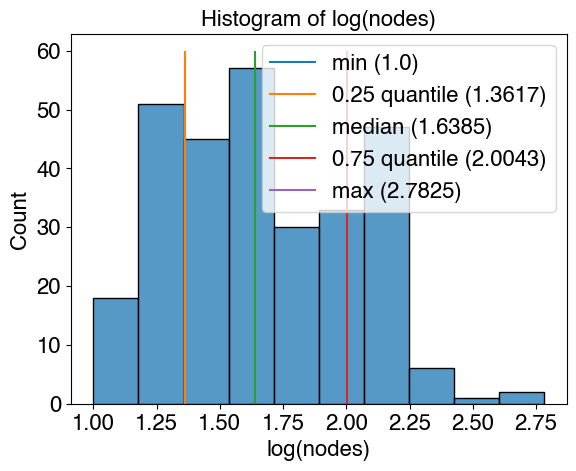

avg_degree


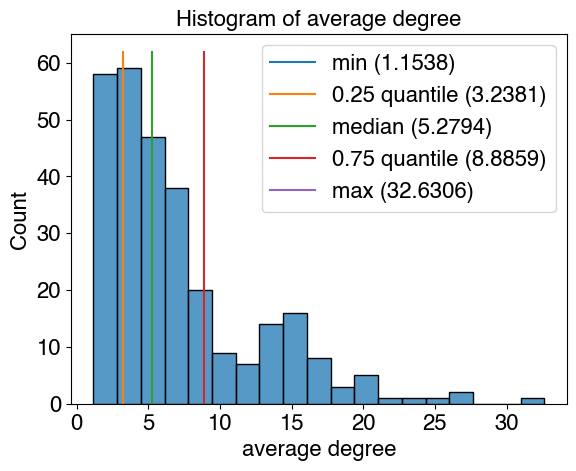

connectance


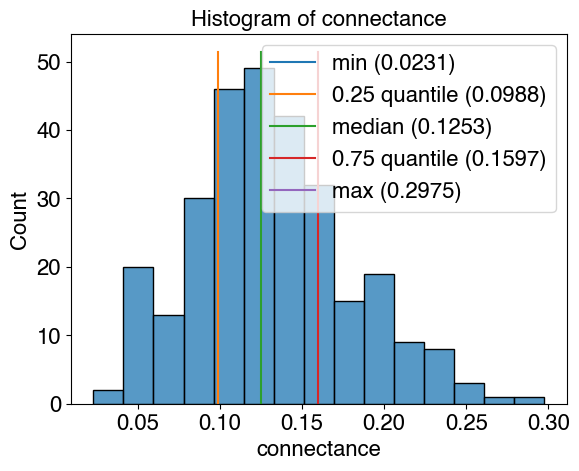

clustering_coefficient


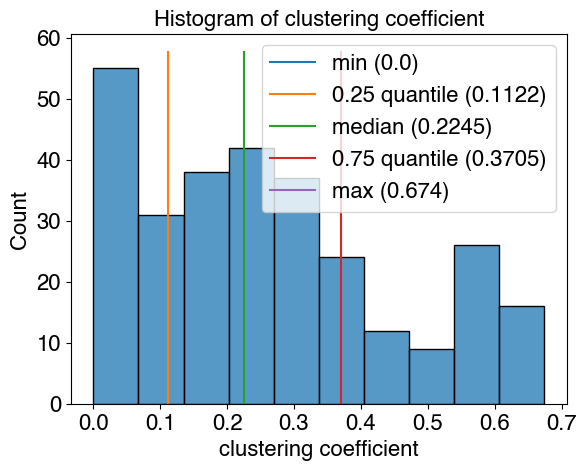

modularity


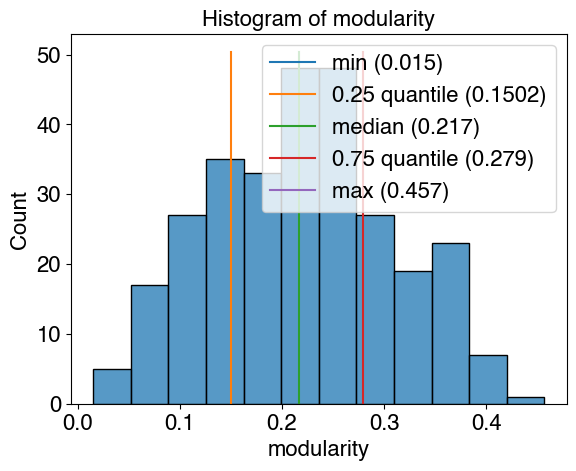

reciprocated_edge


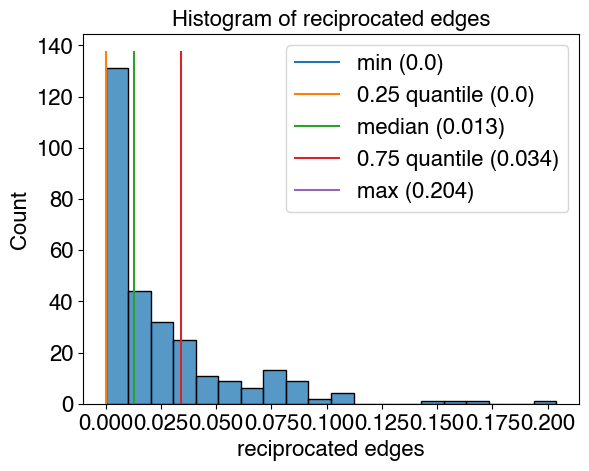

assort_met


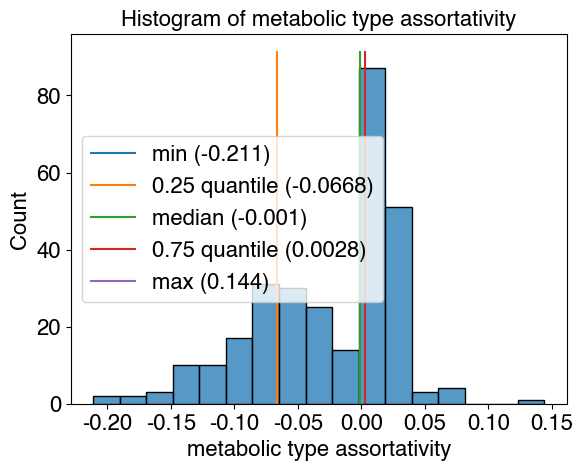

assort_mov


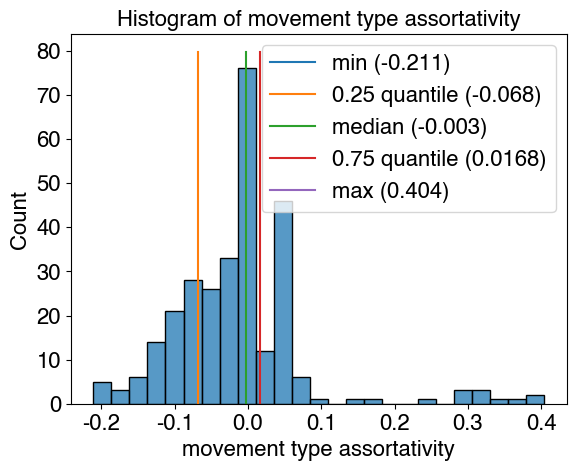

assort_mass


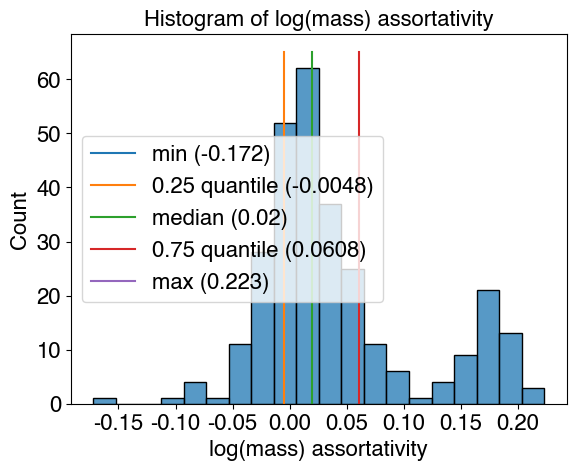

deg_assort_io


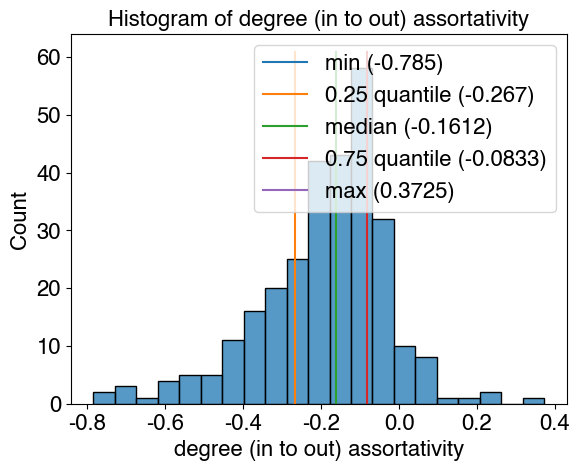

deg_assort_oi


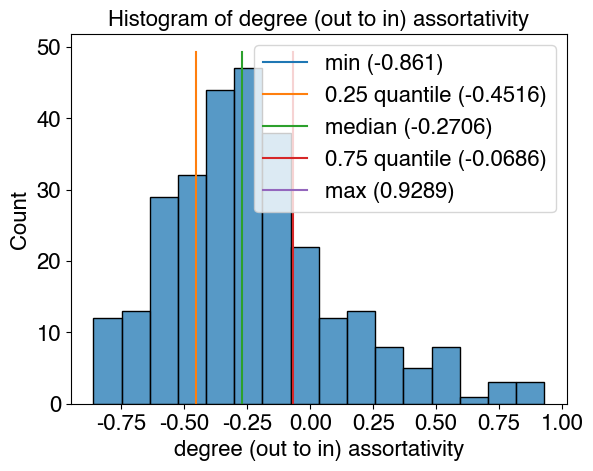

deg_assort_oo


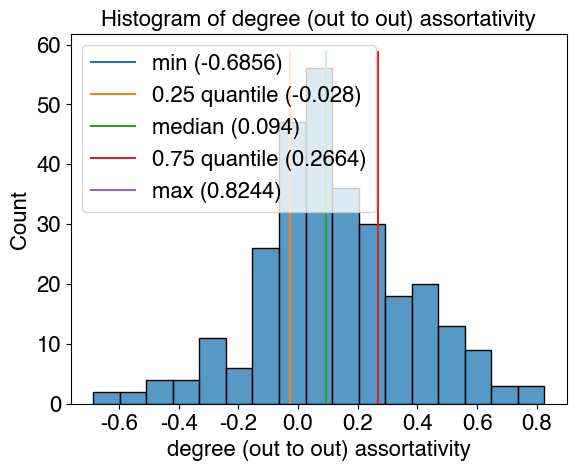

deg_assort_ii


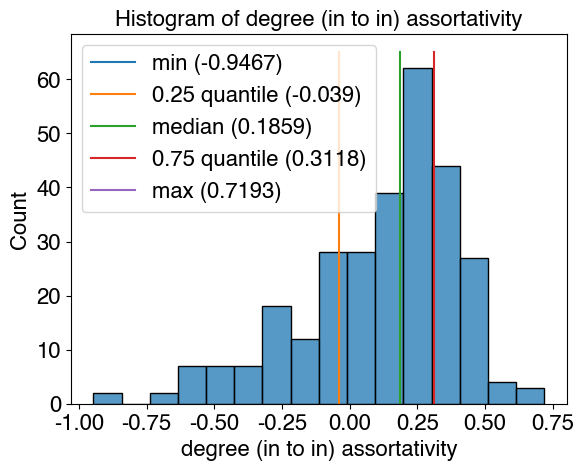

miss_mass_frac


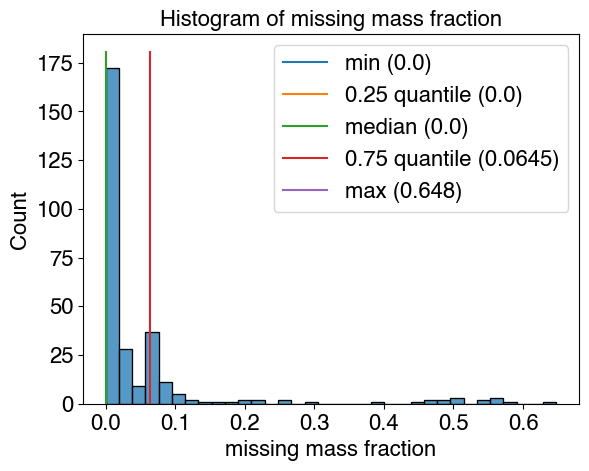

high_tax_frac


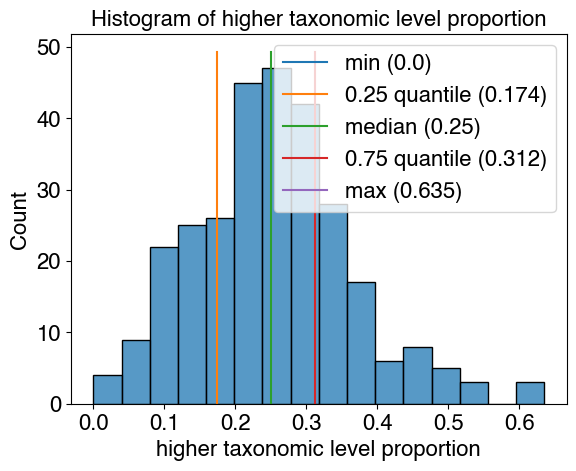

unclassified_tax_frac


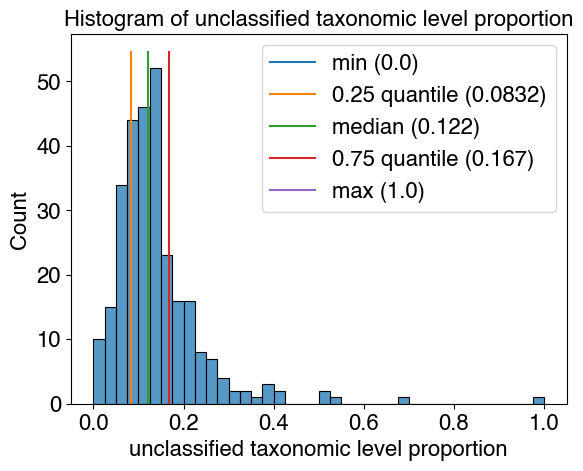

parasitic_removal


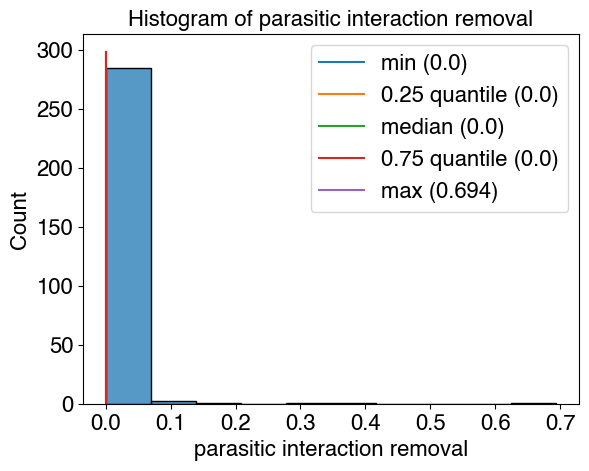

cannibalistic_removal


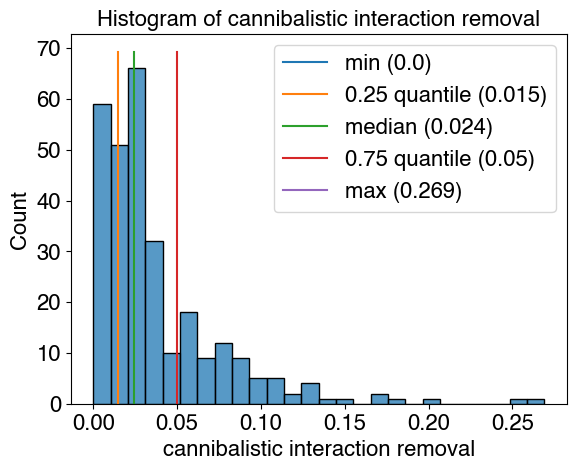

num_attr


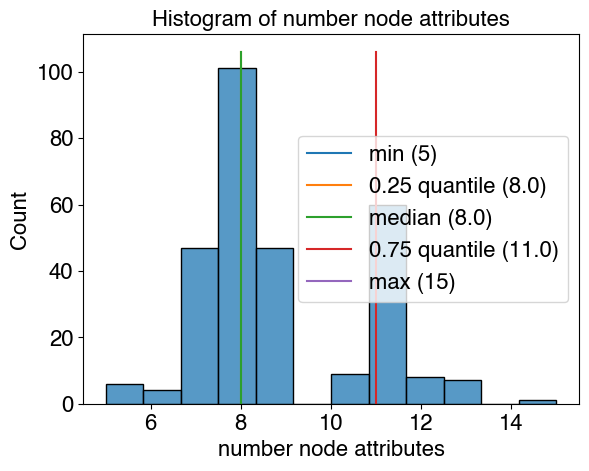

min_log_mass


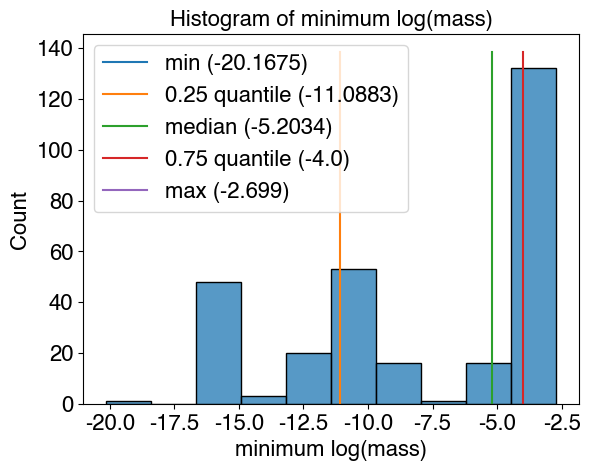

max_log_mass


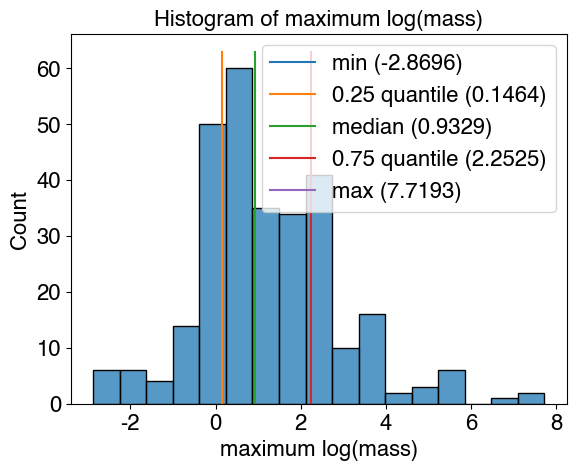

mean_log_mass


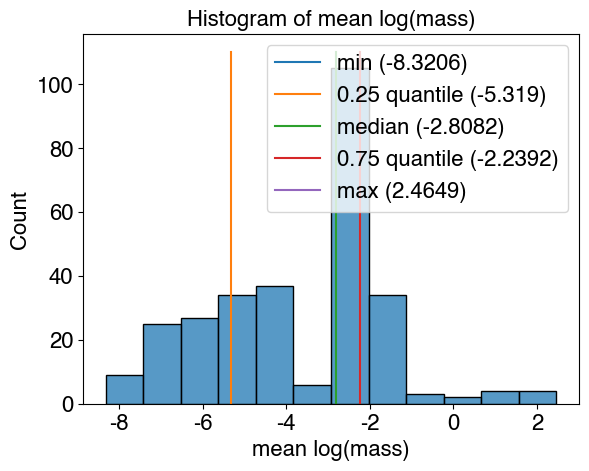

median_log_mass


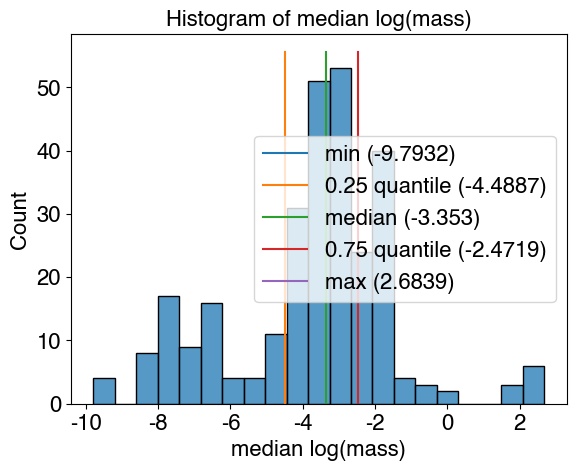

mass_skewness


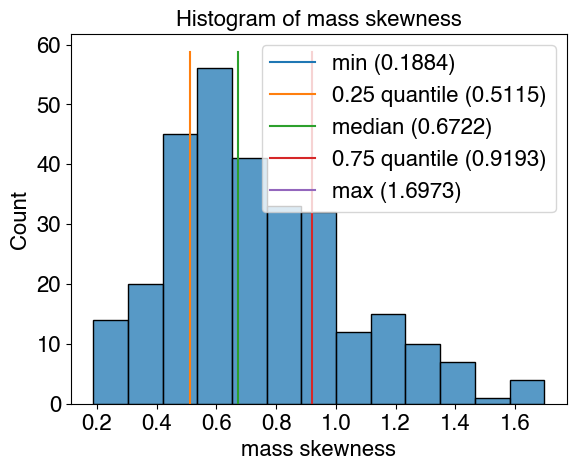

In [29]:
## CELL 27 - Visualize network properties and metadata and save file to CSV
with open('fw_metadata.pickle', 'rb') as handle:
    fw_metadata = pickle.load(handle)

df = pd.DataFrame.from_dict(fw_metadata, orient='index')
df.to_csv(os.path.join(Processed_Data_Folder,'food_web_metadata.csv'))

display_csv = pd.read_csv(os.path.join('..','net_props_display_names.csv'))
display_names = dict(zip(list(display_csv['feat']), list(display_csv['display'])))
display_names['reciprocated_edge'] = 'reciprocated edges'

print(np.median(df['connectance']))
print(np.mean(df['connectance']))

data_processing_helper.property_histogram(df, "log_num_nodes", None,"network_properties",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "avg_degree", None,"network_properties",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "connectance", None,"network_properties",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "clustering_coefficient", None,"network_properties",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "modularity", None,"network_properties",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "reciprocated_edge", None,"network_properties",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "assort_met", None,"assortativities",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "assort_mov", None,"assortativities",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "assort_mass", None,"assortativities",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "deg_assort_io", None,"assortativities",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "deg_assort_oi", None,"assortativities",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "deg_assort_oo", None,"assortativities",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "deg_assort_ii", None,"assortativities",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "miss_mass_frac", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "high_tax_frac", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "unclassified_tax_frac", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "parasitic_removal", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "cannibalistic_removal", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "num_attr", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "min_log_mass", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "max_log_mass", None,"data_details",FONT_SIZE,display_names) 
data_processing_helper.property_histogram(df, "mean_log_mass", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "median_log_mass", None,"data_details",FONT_SIZE,display_names)
data_processing_helper.property_histogram(df, "mass_skewness", None,"data_details",FONT_SIZE,display_names)

In [30]:
## CELL 28 - Report network properties split by ecosystem type in a table
with open('fw_metadata.pickle', 'rb') as handle:
    fw_metadata = pickle.load(handle)

df = pd.read_csv(os.path.join(Processed_Data_Folder,'food_web_metadata.csv'))
property_names = list(df.columns)[3:]

type_properties = {}
for eco_type in ['streams', 'terrestrial aboveground', 'terrestrial belowground', 'lakes', 'marine']:
    df_filtered = df[df['ecosystem.type'] == eco_type]
    type_properties[eco_type] = {'fw_num': len(df_filtered)}
    for prop_name in property_names:
        type_properties[eco_type][f'{prop_name}_min'] = np.min(df_filtered[prop_name])
        type_properties[eco_type][f'{prop_name}_25quant'] = np.quantile(df_filtered[prop_name],0.25)
        type_properties[eco_type][f'{prop_name}_median'] = np.median(df_filtered[prop_name])
        type_properties[eco_type][f'{prop_name}_mean'] = np.mean(df_filtered[prop_name])
        type_properties[eco_type][f'{prop_name}_75quant'] = np.quantile(df_filtered[prop_name],0.75)
        type_properties[eco_type][f'{prop_name}_max'] = np.max(df_filtered[prop_name])
type_prop_df = pd.DataFrame.from_dict(type_properties)
type_prop_df.to_csv(os.path.join(Processed_Data_Folder,'eco_type_metadata.csv'))